
# **Bachelor Thesis: Integrated Gradients and Aversarial examples**



In [ ]:
#@title Define basic functionality of IG
# References: https://www.tensorflow.org/tutorials/interpretability/integrated_gradients
#             https://www.tensorflow.org/tutorials/generative/adversarial_fgsm
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import datasets, layers, models




model = tf.keras.Sequential([
    hub.KerasLayer(
        name='inception_v1',
        handle='https://tfhub.dev/google/imagenet/inception_v1/classification/4',
        trainable=False),
])
model.build([None, 224, 224, 3])
model.summary()

def top_k_predictions(img, k=3):
  image_batch = tf.expand_dims(img, 0)
  predictions = model(image_batch)
  probs = tf.nn.softmax(predictions, axis=-1)
  top_probs, top_idxs = tf.math.top_k(input=probs, k=k)
  top_labels = imagenet_labels[tuple(top_idxs)]
  return top_labels, top_probs[0]

def load_imagenet_labels(file_path):
  labels_file = tf.keras.utils.get_file('ImageNetLabels.txt', file_path)
  with open(labels_file) as reader:
    f = reader.read()
    labels = f.splitlines()
  return np.array(labels)

imagenet_labels = load_imagenet_labels('https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

def read_image(file_name):
  image = tf.io.read_file(file_name)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize_with_pad(image, target_height=224, target_width=224)
  return image

img_url = {
    'Fireboat': 'http://storage.googleapis.com/download.tensorflow.org/example_images/San_Francisco_fireboat_showing_off.jpg',
    'Giant Panda': 'http://storage.googleapis.com/download.tensorflow.org/example_images/Giant_Panda_2.jpeg',
    #'Black Beetle': 'http://storage.googleapis.com/download.tensorflow.org/example_images/Lucanus.jpeg',
    }

img_paths = {name: tf.keras.utils.get_file(name, url) for (name, url) in img_url.items()}
img_name_tensors = {name: read_image(img_path) for (name, img_path) in img_paths.items()}

baseline = tf.zeros(shape=(224,224,3))

def interpolate_images(baseline,
                       image,
                       alphas):
  alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
  baseline_x = tf.expand_dims(baseline, axis=0)

  input_x = tf.expand_dims(image, axis=0)

  delta = input_x - baseline_x

  images = baseline_x +  alphas_x * delta
  return images

def compute_gradients(images, target_class_idx, model):
  with tf.GradientTape() as tape:
    tape.watch(images)
    logits = model(images)
    probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
  return tape.gradient(probs, images)


def integral_approximation(gradients):
  # riemann_trapezoidal
  grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
  integrated_gradients = tf.math.reduce_mean(grads, axis=0)
  return integrated_gradients


@tf.function
def integrated_gradients(baseline,
                         image,
                         target_class_idx,
                         model,
                         m_steps=50,
                         batch_size=32):
  # 1. Generate alphas.
  alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

  # Initialize TensorArray outside loop to collect gradients.
  gradient_batches = tf.TensorArray(tf.float32, size=m_steps+1)

  # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
  for alpha in tf.range(0, len(alphas), batch_size):
    #print("loop" + str(image.shape))
    from_ = alpha
    to = tf.minimum(from_ + batch_size, len(alphas))
    alpha_batch = alphas[from_:to]
    # 2. Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                       image=image,
                                                       alphas=alpha_batch)

    # 3. Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(images=interpolated_path_input_batch,
                                       target_class_idx=target_class_idx,
                                       model=model)

    # Write batch indices and gradients to extend TensorArray.
    gradient_batches = gradient_batches.scatter(tf.range(from_, to), gradient_batch)

  # Stack path gradients together row-wise into single tensor.
  total_gradients = gradient_batches.stack()

  # 4. Integral approximation through averaging gradients.
  avg_gradients = integral_approximation(gradients=total_gradients)
  #print(f"vorher {image.shape}")
  # 5. Scale integrated gradients with respect to input.
  integrated_gradients = (image - baseline) * avg_gradients
  #print(f"nachher {image.shape}")

  return integrated_gradients

def plot_img_attributions(baseline,
                          image,
                          target_class_idx,
                          model,
                          m_steps=50,
                          cmap=None,
                          overlay_alpha=0.4):

  attributions = integrated_gradients(baseline=baseline,
                                      image=image,
                                      target_class_idx=target_class_idx,
                                      model=model,
                                      m_steps=m_steps)

  # Sum of the attributions across color channels for visualization.
  # The attribution mask shape is a grayscale image with height and width
  # equal to the original image.
  attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

  fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))



  axs[0, 0].set_title('Baseline image')
  axs[0, 0].imshow(baseline)
  axs[0, 0].axis('off')

  axs[0, 1].set_title('Original image')
  axs[0, 1].imshow(image)
  axs[0, 1].axis('off')

  axs[1, 0].set_title('Attribution mask')
  axs[1, 0].imshow(attribution_mask, cmap=cmap)
  axs[1, 0].axis('off')

  axs[1, 1].set_title('Overlay')
  axs[1, 1].imshow(attribution_mask, cmap=cmap)
  axs[1, 1].imshow(image, alpha=overlay_alpha)
  axs[1, 1].axis('off')

  plt.tight_layout()
  return fig

#_ = plot_img_attributions(image=img_name_tensors['Fireboat'],
#                          baseline=baseline,
#                          target_class_idx=555,
#                          m_steps=240,
#                          model=model,
#                          cmap=plt.cm.inferno,
#                          overlay_alpha=0.4)

#_ = plot_img_attributions(image=img_name_tensors['Giant Panda'],
#                          baseline=baseline,
#                          target_class_idx=389,
#                          m_steps=55,
#                          model=model,
#                          cmap=plt.cm.viridis,
#                         overlay_alpha=0.5)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v1 (KerasLayer)   (None, 1001)              6633209   
                                                                 
Total params: 6,633,209
Trainable params: 0
Non-trainable params: 6,633,209
_________________________________________________________________
819200/802859 [==============================] - 0s 0us/step


# Experiment 1: Analysing differences of decisions from multiple models on the same data:

In [ ]:
#@title Build multiple Networks and let them analyse the same data
inception_v3 = tf.keras.Sequential([
    hub.KerasLayer(
        name='inception_v3',
        handle='https://tfhub.dev/google/tf2-preview/inception_v3/classification/4',
        trainable=False),
])
inception_v3.build([None, 224, 224, 3])
inception_v3.summary()

mobilenet_v2_130_224 = tf.keras.Sequential([
    hub.KerasLayer(
        name='mobilenet_v2_130_224',
        handle='https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5',
        trainable=False),
])
mobilenet_v2_130_224.build([None, 224, 224, 3])
mobilenet_v2_130_224.summary()

_ = plot_img_attributions(image=img_name_tensors['Giant Panda'],
                          baseline=baseline,
                          target_class_idx=388,
                          m_steps=240,
                          model=model,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4)

_ = plot_img_attributions(image=img_name_tensors['Giant Panda'],
                          baseline=baseline,
                          target_class_idx=388,
                          m_steps=240,
                          model=inception_v3,
                           cmap=plt.cm.inferno,
                           overlay_alpha=0.4)

_ = plot_img_attributions(image=img_name_tensors['Giant Panda'],
                          baseline=baseline,
                          target_class_idx=388,
                          m_steps=240,
                          model=mobilenet_v2_130_224,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (KerasLayer)   (None, 1001)              23853833  
                                                                 
Total params: 23,853,833
Trainable params: 0
Non-trainable params: 23,853,833
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_v2_130_224 (Keras  (None, 1001)             5432713   
 Layer)                                                          
                                                                 
Total params: 5,432,713
Trainable params: 0
Non-trainable params: 5,432,713
_________________________________________________________________


# Experiment 2: Making changes to the baseline


NameError: ignored

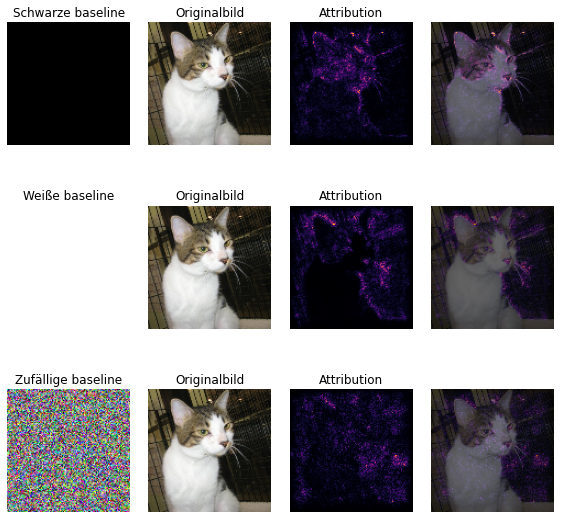

In [ ]:
#@title Compare results for 3 different Baselines on one Image
black_baseline = tf.zeros(shape=(112,112,3))
white_baseline = tf.ones(shape=(112,112,3))
random_baseline = tf.random.uniform(shape=(112,112,3), minval=0.0, maxval=1.0)

def plot_img_attributions_multiple_baselines(first_baseline, second_baseline, third_baseline,
                          image,
                          target_class_idx,
                          model,
                          m_steps=50,
                          cmap=None,
                          overlay_alpha=0.4):
    first_attributions = integrated_gradients(baseline=first_baseline,
                                      image=image,
                                      target_class_idx=target_class_idx,
                                      model=model,
                                      m_steps=m_steps)
    second_attributions = integrated_gradients(baseline=second_baseline,
                                      image=image,
                                      target_class_idx=target_class_idx,
                                      model=model,
                                      m_steps=m_steps)
    third_attributions = integrated_gradients(baseline=third_baseline,
                                      image=image,
                                      target_class_idx=target_class_idx,
                                      model=model,
                                      m_steps=m_steps)

  # Sum of the attributions across color channels for visualization.
  # The attribution mask shape is a grayscale image with height and width
  # equal to the original image.
    first_attribution_mask = tf.reduce_sum(tf.math.abs(first_attributions), axis=-1)
    second_attribution_mask = tf.reduce_sum(tf.math.abs(second_attributions), axis=-1)
    third_attribution_mask = tf.reduce_sum(tf.math.abs(third_attributions), axis=-1)

    fig, axs = plt.subplots(nrows=3, ncols=4, squeeze=False, figsize=(8, 8))

    axs[0, 0].set_title('Schwarze baseline')
    axs[0, 0].imshow(first_baseline)
    axs[0, 0].axis('off')

    axs[0, 1].set_title('Originalbild')
    axs[0, 1].imshow(image)
    axs[0, 1].axis('off')

    axs[0, 2].set_title('Attribution')
    axs[0, 2].imshow(first_attribution_mask, cmap=cmap)
    axs[0, 2].axis('off')

    axs[0, 3].imshow(first_attribution_mask, cmap=cmap)
    axs[0, 3].imshow(image, alpha=overlay_alpha)
    axs[0, 3].axis('off')

    axs[1, 0].set_title('Weiße baseline')
    axs[1, 0].imshow(second_baseline)
    axs[1, 0].axis('off')

    axs[1, 1].set_title('Originalbild')
    axs[1, 1].imshow(image)
    axs[1, 1].axis('off')

    axs[1, 2].set_title('Attribution')
    axs[1, 2].imshow(second_attribution_mask, cmap=cmap)
    axs[1, 2].axis('off')

    axs[1, 3].imshow(second_attribution_mask, cmap=cmap)
    axs[1, 3].imshow(image, alpha=overlay_alpha)
    axs[1, 3].axis('off')

    axs[2, 0].set_title('Zufällige baseline')
    axs[2, 0].imshow(third_baseline)
    axs[2, 0].axis('off')

    axs[2, 1].set_title('Originalbild')
    axs[2, 1].imshow(image)
    axs[2, 1].axis('off')

    axs[2, 2].set_title('Attribution')
    axs[2, 2].imshow(third_attribution_mask, cmap=cmap)
    axs[2, 2].axis('off')

    axs[2, 3].imshow(third_attribution_mask, cmap=cmap)
    axs[2, 3].imshow(image, alpha=overlay_alpha)
    axs[2, 3].axis('off')

    plt.tight_layout()
    return fig

#_ = plot_img_attributions_multiple_baselines(image=img_name_tensors['Giant Panda'],
#                          first_baseline=baseline,
#                          second_baseline=white_baseline,
#                          third_baseline=random_baseline,
#                          target_class_idx=388,
#                          m_steps=240,
#                          model=model,
#                          cmap=plt.cm.inferno,
#                          overlay_alpha=0.4)

#_ = plot_img_attributions_multiple_baselines(image=img_name_tensors['Black Beetle'],
#                          first_baseline=baseline,
#                          second_baseline=white_baseline,
#                          third_baseline=random_baseline,
#                          target_class_idx=307,
#                          m_steps=240,
#                          model=model,
#                          cmap=plt.cm.inferno,
#                          overlay_alpha=0.4)

cvsd_test_batch, cvsd_label_batch = next(iter(validation_batches.take(1)))
_ = plot_img_attributions_multiple_baselines(image=cvsd_test_batch[0],
                          first_baseline=black_baseline,
                          second_baseline=white_baseline,
                          third_baseline=random_baseline,
                          target_class_idx=cvsd_label_batch[0],
                          m_steps=240,
                          model=model,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4)

# Experiment 3: Analysing the results of adversarial attacks.


In [ ]:
#@title Overload
def plot_img_attributions_adversarials(baseline, signed_gradient,
                          image,
                          adversarial_image,
                          target_class_idx,
                          model,
                          m_steps=50,
                          cmap=None,
                          overlay_alpha=0.4):
    attributions = integrated_gradients(baseline=baseline,
                                      image=adversarial_image,
                                      target_class_idx=target_class_idx,
                                      model=model,
                                      m_steps=m_steps)


  # Sum of the attributions across color channels for visualization.
  # The attribution mask shape is a grayscale image with height and width
  # equal to the original image.
    attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

    fig, axs = plt.subplots(nrows=3, ncols=2, squeeze=False, figsize=(8, 8))

    axs[0, 0].set_title('Baseline image')
    axs[0, 0].imshow(baseline)
    axs[0, 0].axis('off')

    axs[0, 1].set_title('Signed Gradient')
    axs[0, 1].imshow(signed_gradient)
    axs[0, 1].axis('off')

    axs[1, 0].set_title('Original Image')
    axs[1, 0].imshow(image)
    axs[1, 0].axis('off')

    axs[1, 1].set_title('Adversarial example')
    axs[1, 1].imshow(adversarial_image)
    axs[1, 1].axis('off')

    axs[2, 0].set_title('Attribution Mask')
    axs[2, 0].imshow(attribution_mask, cmap=cmap)
    axs[2, 0].axis('off')

    axs[2, 1].set_title('Overlay')
    axs[2, 1].imshow(attribution_mask, cmap=cmap)
    axs[2, 1].imshow(adversarial_image, alpha=overlay_alpha)
    axs[2, 1].axis('off')

    plt.tight_layout()
    return fig

49152/35363 [=========================================] - 0s 0us/step


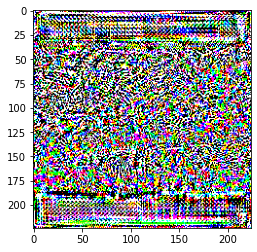

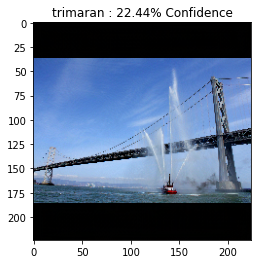

In [ ]:
#@title Generate Adversarials with FGSM and put them trough IG
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions
loss_object = tf.keras.losses.CategoricalCrossentropy()

def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize_with_pad(image, target_height=224, target_width=224)
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

def create_adversarial_pattern(input_image, input_label, model):
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = loss_object(input_label, prediction)
    #print(f"prediction= {prediction}")
    #print(f"loss= {loss}")

  # Get the gradients of the loss w.r.t to the input image.
  #gradient = tape.gradient(loss, input_image)
  gradient = tape.gradient(loss, input_image)

  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

#image_path = tf.keras.utils.get_file('plane-400x257.jpg','https://www.gardeningknowhow.com/wp-content/uploads/2019/10/plane-400x257.jpg')
#image_path = tf.keras.utils.get_file('_109764568_bearhitbycarbetweenpraidandsovata.jpg', 'https://ichef.bbci.co.uk/news/1024/branded_news/15212/production/_109764568_bearhitbycarbetweenpraidandsovata.jpg')
#image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_path = tf.keras.utils.get_file('San_Francisco_fireboat_showing_off.jpg' ,'http://storage.googleapis.com/download.tensorflow.org/example_images/San_Francisco_fireboat_showing_off.jpg') #'Giant_Panda_2.jpeg', 'http://storage.googleapis.com/download.tensorflow.org/example_images/Giant_Panda_2.jpeg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

labrador_retriever_index = 554
label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))



perturbations = create_adversarial_pattern(input_image=image, input_label=label, model=pretrained_model)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

def display_images(image, description, model):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0] * 0.5 + 0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description, label, confidence*100))
  plt.show()

epsilons = [0, 0.01, 0.07, 0.1, 0.15, 0.25, 0.5, 0.8, 1]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

adversarials = []
for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  adversarials.append(adv_x)




plt.figure()
plt.imshow(adversarials[1][0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(pretrained_model.predict(adversarials[1]))
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()


In [ ]:
#@title Visualize mask difference
def plot_attribution_differences(image, adv, noised_image, original_attribution_mask, adversarial_attribution_mask, noised_attribution_mask):
    fig, axs = plt.subplots(nrows=3, ncols=3, squeeze=False, figsize=(8, 8))

    axs[0, 0].set_title('Originalbild')
    axs[0, 0].imshow(image)
    axs[0, 0].axis('off')

    axs[0, 1].set_title('Adversarial')
    axs[0, 1].imshow(adv)
    axs[0, 1].axis('off')

    axs[0, 2].set_title('Verrauschtes Bild')
    axs[0, 2].imshow(noised_image)
    axs[0, 2].axis('off')

    axs[1, 0].set_title('Originale Attributionen')
    axs[1, 0].imshow(original_attribution_mask, cmap=plt.cm.inferno)
    axs[1, 0].axis('off')

    axs[1, 1].set_title('Attributions adversarial')
    axs[1, 1].imshow(adversarial_attribution_mask, cmap=plt.cm.inferno)
    axs[1, 1].axis('off')

    axs[1, 2].set_title('Attribution verrauscht')
    axs[1, 2].imshow(noised_attribution_mask, cmap=plt.cm.inferno)
    axs[1, 2].axis('off')

    axs[2, 0].imshow(original_attribution_mask, cmap=plt.cm.inferno)
    axs[2, 0].imshow((image), alpha=0.4)
    axs[2, 0].axis('off')

    axs[2, 1].imshow(adversarial_attribution_mask, cmap=plt.cm.inferno)
    axs[2, 1].imshow((adv), alpha=0.4)
    axs[2, 1].axis('off')

    axs[2, 2].imshow(noised_attribution_mask, cmap=plt.cm.inferno)
    axs[2, 2].imshow((noised_image), alpha=0.4)
    axs[2, 2].axis('off')

    plt.tight_layout()
    return fig

def plot_attribution_differences_mnist(image, adv, noised_image, original_attribution_mask, adversarial_attribution_mask, noised_attribution_mask):
    fig, axs = plt.subplots(nrows=3, ncols=3, squeeze=False, figsize=(8, 8))

    axs[0, 0].set_title('Originalbild')
    axs[0, 0].imshow(np.reshape(image, (28, 28)), cmap='gray')
    axs[0, 0].axis('off')

    axs[0, 1].set_title('Adversarial')
    axs[0, 1].imshow(np.reshape(adv, (28, 28)), cmap='gray')
    axs[0, 1].axis('off')

    axs[0, 2].set_title('Verrauschtes Bild')
    axs[0, 2].imshow(np.reshape(noised_image, (28, 28)), cmap='gray')
    axs[0, 2].axis('off')

    axs[1, 0].set_title('Originale Attributionen')
    axs[1, 0].imshow(original_attribution_mask, cmap=plt.cm.inferno)
    axs[1, 0].axis('off')

    axs[1, 1].set_title('Attributions adversarial')
    axs[1, 1].imshow(adversarial_attribution_mask, cmap=plt.cm.inferno)
    axs[1, 1].axis('off')

    axs[1, 2].set_title('Attribution verrauscht')
    axs[1, 2].imshow(noised_attribution_mask, cmap=plt.cm.inferno)
    axs[1, 2].axis('off')

    axs[2, 0].imshow(original_attribution_mask, cmap=plt.cm.inferno)
    axs[2, 0].imshow(np.reshape(image, (28, 28)), cmap='gray', alpha=0.4)
    axs[2, 0].axis('off')

    axs[2, 1].imshow(adversarial_attribution_mask, cmap=plt.cm.inferno)
    axs[2, 1].imshow(np.reshape(adv, (28, 28)), cmap='gray', alpha=0.4)
    axs[2, 1].axis('off')

    axs[2, 2].imshow(noised_attribution_mask, cmap=plt.cm.inferno)
    axs[2, 2].imshow(np.reshape(noised_image, (28, 28)), cmap='gray', alpha=0.4)
    axs[2, 2].axis('off')

    plt.tight_layout()
    return fig

# Experiment 4: Training our own network on CIFAR-10

In [ ]:
#@title Train CNN for CIFAR-10
(cifar_train_images, cifar_train_labels), (cifar_test_images, cifar_test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
cifar_train_images, cifar_test_images = cifar_train_images / 255.0, cifar_test_images / 255.0

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cifar_train_images[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[cifar_train_labels[i][0]])
plt.show()

cifar_model = models.Sequential()
cifar_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
cifar_model.add(layers.MaxPooling2D((2, 2)))
cifar_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cifar_model.add(layers.MaxPooling2D((2, 2)))
cifar_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cifar_model.add(layers.Flatten())
cifar_model.add(layers.Dense(64, activation='relu'))
cifar_model.add(layers.Dense(10, activation='softmax'))

cifar_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = cifar_model.fit(cifar_train_images, cifar_train_labels, epochs=10,
                    validation_data=(cifar_test_images, cifar_test_labels))

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

cifar_test_loss, cifar_test_acc = cifar_model.evaluate(cifar_test_images,  cifar_test_labels, verbose=2)

In [ ]:
import tensorflow_datasets as tfds

(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs',
    split = ('train[:50%]', 'train[50%:]'),
    with_info = True,
    as_supervised = True
)

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image,label

num_examples = info.splits['train'].num_examples

BATCH_SIZE = 32
IMAGE_RES = 112

train_batches = train_examples.cache().shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

train_examples = train_examples.cache().shuffle(num_examples//4).map(format_image)
validation_examples = validation_examples.map(format_image)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete4DNLD0/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


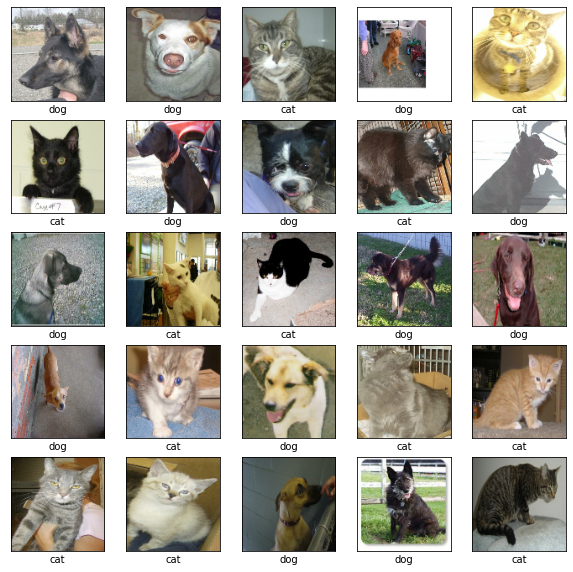

In [ ]:
class_names = np.array(info.features['label'].names)

image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image_batch[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[label_batch[i]])
plt.show()

Epoch 1/3
364/364 [==============================] - 26s 49ms/step - loss: 0.2429 - accuracy: 0.9236 - val_loss: 0.2012 - val_accuracy: 0.9323
Epoch 2/3
364/364 [==============================] - 15s 42ms/step - loss: 0.1655 - accuracy: 0.9408 - val_loss: 0.2053 - val_accuracy: 0.9353
Epoch 3/3
364/364 [==============================] - 15s 42ms/step - loss: 0.1604 - accuracy: 0.9447 - val_loss: 0.2016 - val_accuracy: 0.9349
Labels: [1 0 1 1 1 1 1 0 0 0 1 1 1 0 0 1 0 1 1 0 1 0 1 0 1 0 0 0 1 1 1 0]
Predicted_labels: [1 0 1 1 1 1 1 1 0 0 1 1 1 0 0 0 0 1 1 0 1 0 1 0 1 0 0 0 1 1 1 0]


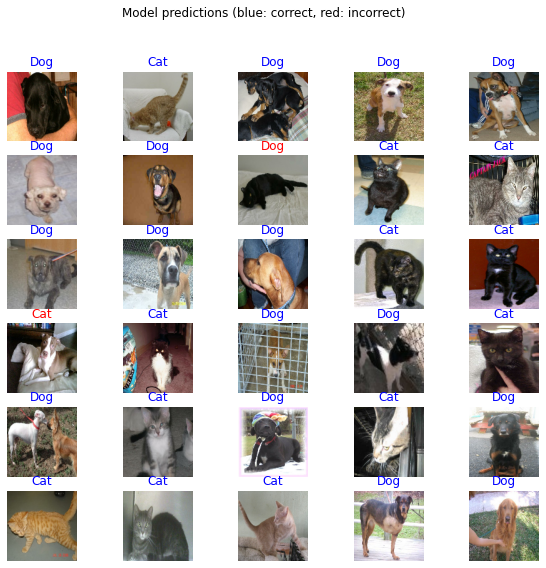

In [ ]:
URL = "https://tfhub.dev/google/imagenet/inception_v1/classification/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape = (IMAGE_RES,IMAGE_RES,3))
cvsd_model_inception = tf.keras.Sequential([
                             feature_extractor,
                             layers.Dense(2)
])
cvsd_model_inception.compile(
    optimizer = 'adam',
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
history = cvsd_model_inception.fit(train_batches,
                    epochs = 3,
                    validation_data = validation_batches)

class_names = np.array(info.features['label'].names)
class_names

image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = cvsd_model_inception.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

print('Labels:', label_batch)
print('Predicted_labels:', predicted_ids)

plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_= plt.suptitle("Model predictions (blue: correct, red: incorrect)")

In [ ]:
cvsd_model = models.Sequential()
cvsd_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(112, 112, 3)))
cvsd_model.add(layers.MaxPooling2D((2, 2)))
cvsd_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cvsd_model.add(layers.MaxPooling2D((2, 2)))
cvsd_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cvsd_model.add(layers.Flatten())
cvsd_model.add(layers.Dense(64, activation='relu'))
cvsd_model.add(layers.Dense(10, activation='softmax'))

cvsd_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = cvsd_model.fit(train_batches, epochs=4,
                    validation_data=validation_batches)

Epoch 1/4


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


364/364 [==============================] - 28s 38ms/step - loss: 0.6498 - accuracy: 0.6340 - val_loss: 0.5621 - val_accuracy: 0.6975
Epoch 2/4
364/364 [==============================] - 10s 29ms/step - loss: 0.5263 - accuracy: 0.7423 - val_loss: 0.4947 - val_accuracy: 0.7600
Epoch 3/4
364/364 [==============================] - 11s 31ms/step - loss: 0.4632 - accuracy: 0.7763 - val_loss: 0.4760 - val_accuracy: 0.7694
Epoch 4/4
364/364 [==============================] - 11s 30ms/step - loss: 0.4067 - accuracy: 0.8105 - val_loss: 0.4448 - val_accuracy: 0.7940


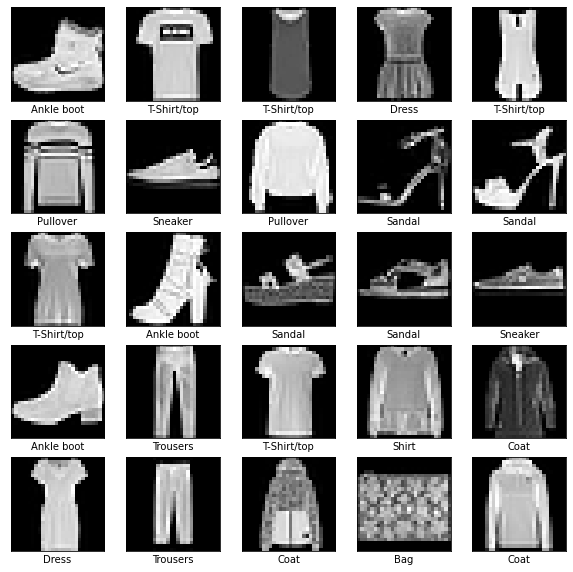

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1875/1875 [==============================] - 11s 6ms/step - loss: 0.4936 - accuracy: 0.8207 - val_loss: 0.3736 - val_accuracy: 0.8640
Epoch 2/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3178 - accuracy: 0.8841 - val_loss: 0.3366 - val_accuracy: 0.8778
Epoch 3/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2745 - accuracy: 0.8994 - val_loss: 0.2948 - val_accuracy: 0.8915
Epoch 4/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2419 - accuracy: 0.9092 - val_loss: 0.2773 - val_accuracy: 0.8995
Epoch 5/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2190 - accuracy: 0.9195 - val_loss: 0.2605 - val_accuracy: 0.9074
313/313 - 1s - loss: 0.2605 - accuracy: 0.9074 - 705ms/epoch - 2ms/step


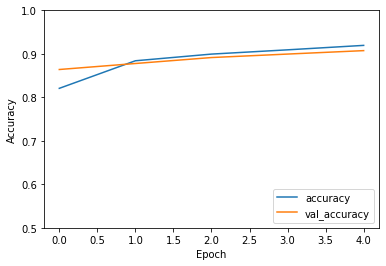

In [ ]:
#@title Train CNN for mnist
#(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
(mnist_train_images, mnist_train_labels), (mnist_test_images, mnist_test_labels) = datasets.fashion_mnist.load_data()

# Normalize pixel values to be between 0 and 1
mnist_train_images, mnist_test_images = mnist_train_images / 255.0, mnist_test_images / 255.0

class_names = ['T-Shirt/top', 'Trousers', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(mnist_train_images[i], cmap="gray")
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[mnist_train_labels[i]])
plt.show()

mnist_model = models.Sequential()
mnist_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
mnist_model.add(layers.MaxPooling2D((2, 2)))
mnist_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
mnist_model.add(layers.MaxPooling2D((2, 2)))
mnist_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
mnist_model.add(layers.Flatten())
mnist_model.add(layers.Dense(64, activation='relu'))
mnist_model.add(layers.Dense(10, activation='softmax'))

mnist_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = mnist_model.fit(mnist_train_images, mnist_train_labels, epochs=5,
                    validation_data=(mnist_test_images, mnist_test_labels))

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

mnist_test_loss, mnist_test_acc = mnist_model.evaluate(mnist_test_images,  mnist_test_labels, verbose=2)

In [ ]:
#@title Plot func for MNIST
def plot_img_attributions_mnist(baseline,
                          image,
                          target_class_idx,
                          model,
                          m_steps=50,
                          cmap=None,
                          overlay_alpha=0.4):
  image = tf.expand_dims(image, axis=-1)

  attributions = integrated_gradients(baseline=baseline,
                                      image=image,
                                      target_class_idx=target_class_idx,
                                      model=model,
                                      m_steps=m_steps)

  attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)


  fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))

  axs[0, 0].set_title('Baseline image')
  axs[0, 0].imshow(np.reshape(baseline, (28, 28)), cmap='gray')
  axs[0, 0].axis('off')

  axs[0, 1].set_title('Original image')
  axs[0, 1].imshow(np.reshape(image, (28, 28)), cmap='gray')
  axs[0, 1].axis('off')

  axs[1, 0].set_title('Attribution mask')
  axs[1, 0].imshow(attribution_mask, cmap=cmap)
  axs[1, 0].axis('off')

  axs[1, 1].set_title('Overlay')
  axs[1, 1].imshow(attribution_mask, cmap=cmap)
  axs[1, 1].imshow(np.reshape(image, (28, 28)), cmap='gray', alpha=overlay_alpha)
  axs[1, 1].axis('off')

  plt.tight_layout()
  return fig

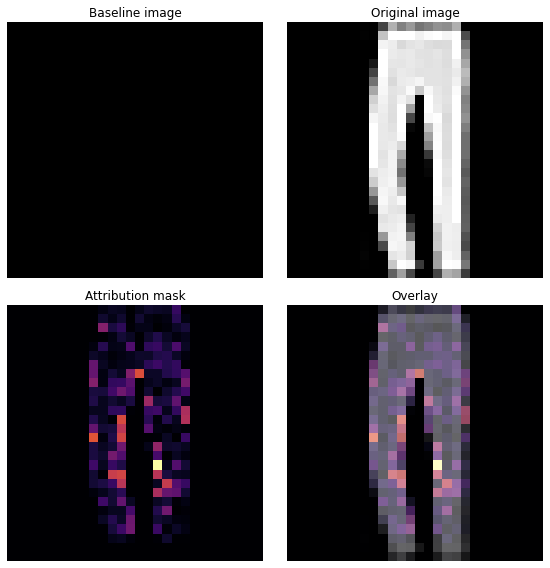

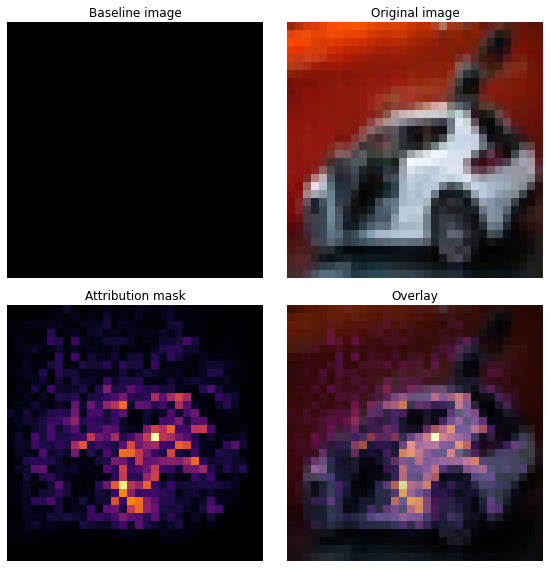

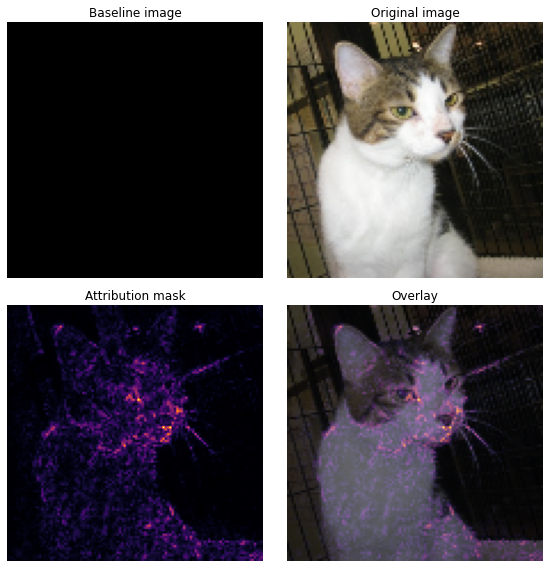

In [ ]:
#@title IG for the new Datasets
baseline_28 = tf.zeros(shape=(28,28,1));
baseline_32 = tf.zeros(shape=(32,32,3));



_ = plot_img_attributions_mnist(image=np.float32(mnist_test_images[2]),
                          baseline=baseline_28,
                          target_class_idx=mnist_test_labels[2].item(),
                          m_steps=240,
                          model=mnist_model,                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4)

_ = plot_img_attributions(image=np.float32(cifar_test_images[6]),
                          baseline=baseline_32,
                          target_class_idx=cifar_test_labels[6].item(),
                          m_steps=240,
                          model=cifar_model,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4)

cvsd_test_batch, cvsd_label_batch = next(iter(validation_batches.take(1)))
_ = plot_img_attributions(image=np.float32(cvsd_test_batch[0]),
                          baseline=tf.zeros(shape=(112,112,3)),
                          target_class_idx=cvsd_label_batch[0],
                          m_steps=240,
                          model=model,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4)

[[1.49815776e-07 5.62693572e-07 6.37130597e-06 ... 1.57230602e-06 0 0]
 [9.39521598e-08 4.25806348e-07 1.84042483e-06 ... 1.05275103e-05 0 0]
 [2.91680817e-06 2.83878944e-06 9.45193642e-06 ... 9.70317251e-06 0 0]
 ...
 [9.76177716e-07 3.66130939e-06 7.77742e-06 ... 4.30803175e-06 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


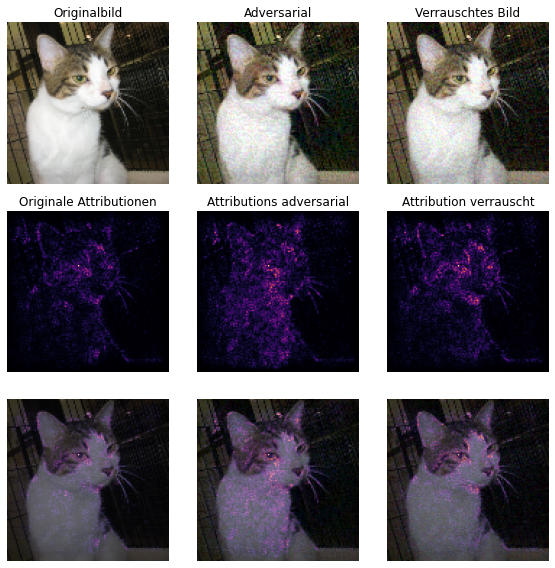

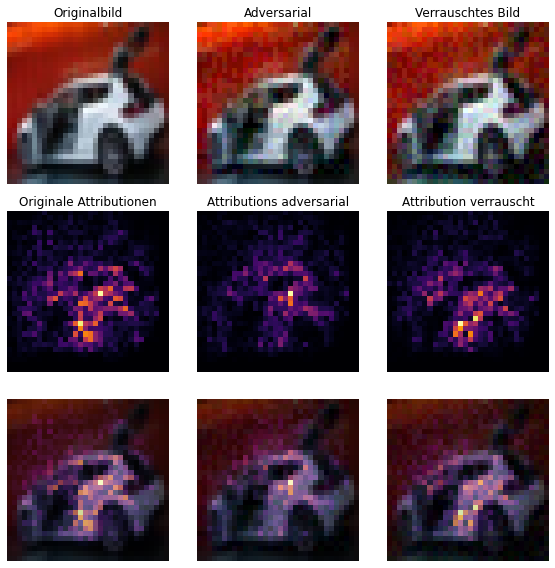

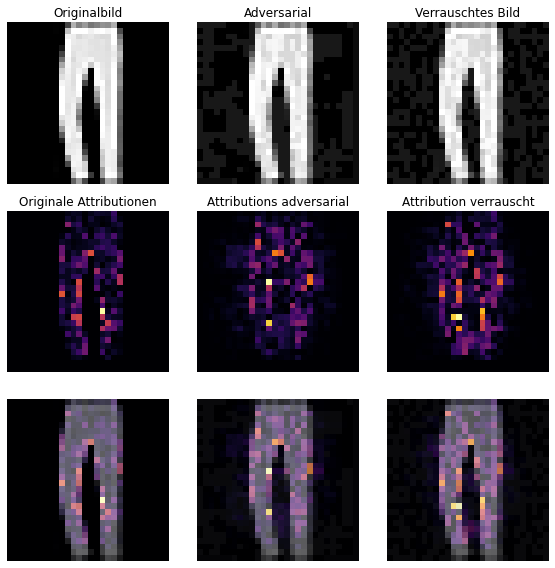

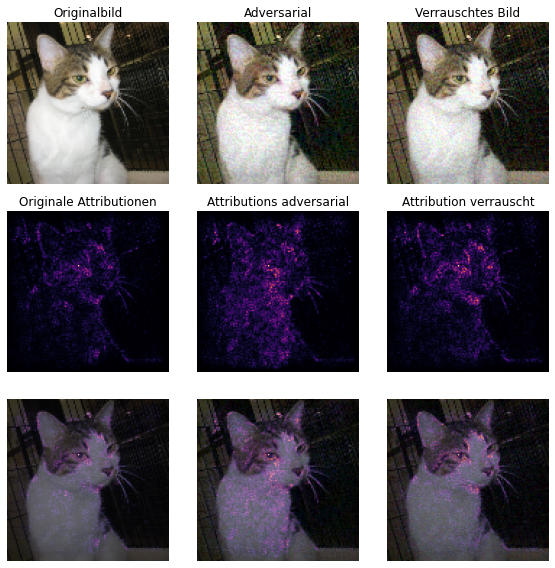

In [ ]:
#@title Visualize different Attributions
image = np.float32(cifar_test_images[6])
image = image.reshape(1,32,32,3)
image_probs = cifar_model.predict(image)
image = tf.convert_to_tensor(image, dtype=tf.float32)


label = tf.one_hot(cifar_test_labels[6].item(), image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))
perturbations = create_adversarial_pattern(input_image=image, input_label=label, model=cifar_model)
adv = image + 0.05*perturbations
adv = tf.clip_by_value(adv, -1, 1)

noise = np.random.randint(0,2, (1,32,32,3))  #tf.random.uniform(shape=(baseline.shape), minval=0.0, maxval=1.0)
noise[noise == 0] = -1
noise = tf.convert_to_tensor(noise, dtype=tf.float32)
noised_image = image + 0.05*noise
noised_image = tf.clip_by_value(noised_image, -1, 1)

original_attributions = integrated_gradients(baseline=tf.zeros(shape=(32,32,3)),
                                      image=(image[0]),
                                      target_class_idx=cifar_test_labels[6].item(),
                                      model=cifar_model,
                                      m_steps=240)
original_attribution_mask = tf.reduce_sum(tf.math.abs(original_attributions), axis=-1)
adversarial_attributions = integrated_gradients(baseline=tf.zeros(shape=(32,32,3)),
                                      image=(adv[0]),
                                      target_class_idx=cifar_test_labels[6].item(),
                                      model=cifar_model,
                                      m_steps=240)
adversarial_attribution_mask = tf.reduce_sum(tf.math.abs(adversarial_attributions), axis=-1)

noised_attributions = integrated_gradients(baseline=tf.zeros(shape=(32,32,3)),
                                      image=((noised_image[0])),
                                      target_class_idx=cifar_test_labels[6].item(),
                                      model=cifar_model,
                                      m_steps=240)
noised_attribution_mask = tf.reduce_sum(tf.math.abs(noised_attributions), axis=-1)
#tf.print(noised_attribution_mask)
plot_attribution_differences(image[0], adv[0], noised_image[0], original_attribution_mask, adversarial_attribution_mask, noised_attribution_mask)






image = np.float32(mnist_test_images[2])
image = image.reshape(1,28,28,1)
image_probs = mnist_model.predict(image)
image = tf.convert_to_tensor(image, dtype=tf.float32)


label = tf.one_hot(mnist_test_labels[2].item(), image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))
perturbations = create_adversarial_pattern(input_image=image, input_label=label, model=mnist_model)
adv = image + 0.05*perturbations
adv = tf.clip_by_value(adv, -1, 1)

noise = np.random.randint(0,2, (1,28,28,1))  #tf.random.uniform(shape=(baseline.shape), minval=0.0, maxval=1.0)
noise[noise == 0] = -1
noise = tf.convert_to_tensor(noise, dtype=tf.float32)
noised_image = image + 0.05*noise
noised_image = tf.clip_by_value(noised_image, -1, 1)
original_attributions = integrated_gradients(baseline=tf.zeros(shape=(28,28,1)),
                                      image=(image[0]),
                                      target_class_idx=mnist_test_labels[2].item(),
                                      model=mnist_model,
                                      m_steps=240)
original_attribution_mask = tf.reduce_sum(tf.math.abs(original_attributions), axis=-1)
adversarial_attributions = integrated_gradients(baseline=tf.zeros(shape=(28,28,1)),
                                      image=(adv[0]),
                                      target_class_idx=mnist_test_labels[2].item(),
                                      model=mnist_model,
                                      m_steps=240)
adversarial_attribution_mask = tf.reduce_sum(tf.math.abs(adversarial_attributions), axis=-1)

noised_attributions = integrated_gradients(baseline=tf.zeros(shape=(28,28,1)),
                                      image=(noised_image[0]),
                                      target_class_idx=mnist_test_labels[2].item(),
                                      model=mnist_model,
                                      m_steps=240)
noised_attribution_mask = tf.reduce_sum(tf.math.abs(noised_attributions), axis=-1)
#tf.print(noised_attribution_mask)
plot_attribution_differences_mnist(image[0], adv[0], noised_image[0], original_attribution_mask, adversarial_attribution_mask, noised_attribution_mask)








cvsd_test_batch, cvsd_label_batch = next(iter(validation_batches.take(1)))

image = np.float32(cvsd_test_batch[0])
image = image.reshape(1,112,112,3)
image_probs = cvsd_model.predict(image)
image = tf.convert_to_tensor(image, dtype=tf.float32)

label = tf.one_hot(cvsd_label_batch[0], image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))
perturbations = create_adversarial_pattern(input_image=image, input_label=label, model=cvsd_model)
adv = image + 0.05*perturbations
adv = tf.clip_by_value(adv, -1, 1)

noise = np.random.randint(0,2,(tf.zeros(shape=(112,112,3)).shape))  #tf.random.uniform(shape=(baseline.shape), minval=0.0, maxval=1.0)
noise[noise == 0] = -1
noise = tf.convert_to_tensor(noise, dtype=tf.float32)
noised_image = image + 0.05*noise
noised_image = tf.clip_by_value(noised_image, -1, 1)

original_attributions = integrated_gradients(baseline=tf.zeros(shape=(112,112,3)),
                                      image=(image[0]),
                                      target_class_idx=cvsd_label_batch[0],
                                      model=cvsd_model,
                                      m_steps=240)
original_attribution_mask = tf.reduce_sum(tf.math.abs(original_attributions), axis=-1)
adversarial_attributions = integrated_gradients(baseline=tf.zeros(shape=(112,112,3)),
                                      image=(adv[0]),
                                      target_class_idx=cvsd_label_batch[0],
                                      model=cvsd_model,
                                      m_steps=240)
adversarial_attribution_mask = tf.reduce_sum(tf.math.abs(adversarial_attributions), axis=-1)

noised_attributions = integrated_gradients(baseline=tf.zeros(shape=(112,112,3)),
                                      image=(noised_image[0]),
                                      target_class_idx=cvsd_label_batch[0],
                                      model=cvsd_model,
                                      m_steps=240)
noised_attribution_mask = tf.reduce_sum(tf.math.abs(noised_attributions), axis=-1)
tf.print(noised_attribution_mask)
plot_attribution_differences(image[0], adv[0], noised_image[0], original_attribution_mask, adversarial_attribution_mask, noised_attribution_mask)

In [ ]:
#@title Calculate mse etc.
def calculate_distances_of_masks(baseline, image, target_class_idx, model, epsilons):

    image_probs = model.predict(image)

    label = tf.one_hot(target_class_idx, image_probs.shape[-1])
    label = tf.reshape(label, (1, image_probs.shape[-1]))
    perturbations = create_adversarial_pattern(input_image=image, input_label=label, model=model)
    
    adversarials = []
    misclassifications = []
    
    predictions_with_confidence = []
    for i, eps in enumerate(epsilons):
        adv_x = image + eps*perturbations
        adv_x = tf.clip_by_value(adv_x, -1, 1)

        predictions = model.predict(adv_x)
        ind = np.argmax(predictions)
        predictions = tf.nn.softmax(predictions)
        predictions_with_confidence.append((class_names[ind], predictions[0][ind] * 100))

        if(ind == target_class_idx):
            misclassifications.append(0)
            #print("true")
        else:
            misclassifications.append(1)
            #print("false")

        adversarials.append(adv_x)

    original_attributions = integrated_gradients(baseline=baseline,
                                      image=(image[0]), #* 0.5 + 0.5),
                                      target_class_idx=target_class_idx,
                                      model=model,
                                      m_steps=240)

    original_attribution_mask = tf.reduce_sum(tf.math.abs(original_attributions), axis=-1)

    ax=None
    errors = []
    deviations = []
    rmses = []
    corrs = []
    stds_adv = []

    for index, adversarial in enumerate(adversarials):
        adversarial_attributions = integrated_gradients(baseline=baseline,
                                        image=((adversarial[0])),# * 0.5 + 0.5)),
                                        target_class_idx=target_class_idx,
                                        model=model,
                                        m_steps=240)
        adversarial_attribution_mask = tf.reduce_sum(tf.math.abs(adversarial_attributions), axis=-1)
        mse = (np.square(original_attribution_mask - adversarial_attribution_mask).mean(axis=ax))
        rmse = np.sqrt(mse)
        std = np.std(original_attribution_mask - adversarial_attribution_mask)
        errors.append(mse)
        deviations.append(std)
        rmses.append(rmse)

        std_adv = np.std(adversarial_attribution_mask)
        stds_adv.append(std_adv)

        x = original_attribution_mask.numpy()
        y = adversarial_attribution_mask.numpy()

        x = x.flatten()
        y = y.flatten()

        corr = np.corrcoef(x, y)[0,1]
        corrs.append(corr)

    return errors, deviations, rmses, corrs, misclassifications, stds_adv

def noise_calculate_distances_of_masks(baseline, image, target_class_idx, model, epsilons):

    noise = np.random.randint(0,2,(baseline.shape))  #tf.random.uniform(shape=(baseline.shape), minval=0.0, maxval=1.0)
    noise[noise == 0] = -1
    
    noise = tf.convert_to_tensor(noise, dtype=tf.float32)
    
    adversarials = []
    misclassifications = []
    predictions_with_confidence = []
    for i, eps in enumerate(epsilons):
        adv_x = image + eps*noise
        adv_x = tf.clip_by_value(adv_x, -1, 1)

        adversarials.append(adv_x)

        predictions = model.predict(adv_x)
        ind = np.argmax(predictions)
        predictions = tf.nn.softmax(predictions)
        #print(f"{class_names[ind]}, Confidence: {predictions[0][ind] * 100}%")
        predictions_with_confidence.append((class_names[ind], predictions[0][ind] * 100))
        if(ind == target_class_idx):
            misclassifications.append(0)
            #print("true")
        else:
            misclassifications.append(1)
            #print("false")

    original_attributions = integrated_gradients(baseline=baseline,
                                      image=(image[0]), #* 0.5 + 0.5),
                                      target_class_idx=target_class_idx,
                                      model=model,
                                      m_steps=240)
    original_attribution_mask = tf.reduce_sum(tf.math.abs(original_attributions), axis=-1)
    ax=None
    errors = []
    deviations = []
    rmses = []
    corrs = []
    for index, adversarial in enumerate(adversarials):
        adversarial_attributions = integrated_gradients(baseline=baseline,
                                        image=((adversarial[0])),# * 0.5 + 0.5)),
                                        target_class_idx=target_class_idx,
                                        model=model,
                                        m_steps=240)

        adversarial_attribution_mask = tf.reduce_sum(tf.math.abs(adversarial_attributions), axis=-1)
        mse = (np.square(original_attribution_mask - adversarial_attribution_mask).mean(axis=ax))
        rmse = np.sqrt(mse)
        std = np.std(original_attribution_mask - adversarial_attribution_mask)
        errors.append(mse)
        deviations.append(std)
        rmses.append(rmse)

        x = original_attribution_mask.numpy()
        y = adversarial_attribution_mask.numpy()

        x = x.flatten()
        y = y.flatten()



        corr = np.corrcoef(x, y)[0,1]
        corrs.append(corr)

        #print("Error at Epsilon=" +str(epsilons[index]) + ": " + str(mse))
        #_ = plot_attribution_differences(original_attribution_mask, adversarial_attribution_mask)
    #plot_distances_of_maks(epsilons, errors, deviations, rmses, 1)

    return errors, deviations, rmses, corrs, misclassifications

In [ ]:
from matplotlib.pyplot import jet
epsilons = [0, 0.007, 0.01, 0.015, 0.05, 0.07, 0.1, 0.15, 0.25]
class_names = ["dog", "cat"]
x = 1024.0

mean_errors = [0 for i in range (len(epsilons))]
mean_deviations = [0 for i in range (len(epsilons))]
mean_rmses = [0 for i in range (len(epsilons))]
mean_corrs = [0 for i in range (len(epsilons))]
mean_misclass = [0 for i in range (len(epsilons))]

cvsd_test_batch, cvsd_label_batch = next(iter(validation_batches.take(1)))

for j in range(1,0):
    cvsd_test_batch, cvsd_label_batch = next(iter(validation_batches.take(j)))
    for i in range(0, 0):
            image = np.float32(cvsd_test_batch[i])
            image = image.reshape(1,112,112,3)
            image = tf.convert_to_tensor(image, dtype=tf.float32)
            errors, deviations, rmses, corrs, misclassifications = calculate_distances_of_masks(baseline=tf.zeros(shape=(112,112,3)),image=image,target_class_idx=cvsd_label_batch[i],model=cvsd_model_inception, epsilons=epsilons)
            mean_errors = np.add(mean_errors, errors)
            mean_deviations = np.add(mean_deviations, deviations)
            mean_rmses = np.add(mean_rmses, rmses)
            mean_corrs = np.add(mean_corrs, corrs)
            mean_misclass = np.add(mean_misclass, misclassifications)





mean_errors = np.true_divide(mean_errors, x)
mean_deviations = np.true_divide(mean_deviations, x)
mean_rmses = np.true_divide(mean_rmses, x)
mean_corrs = np.true_divide(mean_corrs, x)
error_rate = np.true_divide(mean_misclass, x)
#print(f"Modelname: selftrained CNN, Dataset = Cats vs. Dogs , X = {x},\n Mean_erros = {mean_errors},\n Mean_standard_deviation = {mean_deviations},\n Mean_corrs = {mean_corrs},\n Mean_misclassifications = {mean_misclass},\n Error_rate = {error_rate}\n")

mean_errors = [0 for i in range (len(epsilons))]
mean_deviations = [0 for i in range (len(epsilons))]
mean_rmses = [0 for i in range (len(epsilons))]
mean_corrs = [0 for i in range (len(epsilons))]
mean_misclass = [0 for i in range (len(epsilons))]

cvsd_test_batch, cvsd_label_batch = next(iter(validation_batches.take(1)))
for j in range(1,33):
    cvsd_test_batch, cvsd_label_batch = next(iter(validation_batches.take(j)))
    for i in range(0, int(32)):
        image = np.float32(cvsd_test_batch[i])
        image = image.reshape(1,112,112,3)
        image = tf.convert_to_tensor(image, dtype=tf.float32)
        errors, deviations, rmses, corrs, misclassifications = noise_calculate_distances_of_masks(baseline=tf.zeros(shape=(112,112,3)),image=image,target_class_idx=cvsd_label_batch[i],model=cvsd_model_inception, epsilons=epsilons)
        mean_errors = np.add(mean_errors, errors)
        mean_deviations = np.add(mean_deviations, deviations)
        mean_rmses = np.add(mean_rmses, rmses)
        mean_corrs = np.add(mean_corrs, corrs)
        mean_misclass = np.add(mean_misclass, misclassifications)





mean_errors = np.true_divide(mean_errors, x)
mean_deviations = np.true_divide(mean_deviations, x)
mean_rmses = np.true_divide(mean_rmses, x)
mean_corrs = np.true_divide(mean_corrs, x)
error_rate = np.true_divide(mean_misclass, x)
print(f"Modelname: Inception_V3, Dataset = Cats vs. Dogs , X = {x},\n Mean_erros = {mean_errors},\n Mean_standard_deviation = {mean_deviations},\n Mean_corrs = {mean_corrs},\n Mean_misclassifications = {mean_misclass},\n Error_rate = {error_rate}\n")

In [ ]:
#@title Graph Plotting
def plot_distances_of_maks(epsilons, errors, deviations, rmses,corrs , x):
    plt.figure()
    #plt.plot(epsilons, np.array(errors, dtype=float), marker='o', label = "Mean Squared Error")
    plt.errorbar(epsilons, np.array([(10**0)*x for x in errors], dtype=float), deviations, label="Mean squared error", ecolor="red", fmt='-o')
    plt.xlabel('Epsilon')
    plt.ylabel("Standard deviation")
    plt.legend()
    plt.title(f'Mean statistics between two masks of different Epsilon Values for {x} images')
    plt.grid()
    plt.show()

    plt.figure()
    plt.plot(epsilons, deviations, marker='o' ,label = "Standard Deviation")
    plt.plot(epsilons, rmses, marker='x',label = "Root Mean Squared Error")
    plt.xlabel('Epsilon')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure()
    plt.plot(epsilons, corrs, color="green" ,marker='o' , label = "Pearson Correlation Coefficient")
    plt.xlabel('Epsilon')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
#@title Claculation for CIFAR Adversarials
epsilons = [0, 0.007, 0.01, 0.015, 0.05, 0.07, 0.1, 0.15, 0.25]
baseline_32 = tf.zeros(shape=(32,32,3));

x = 100.0

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']


mean_errors = [0 for i in range (len(epsilons))]
mean_deviations = [0 for i in range (len(epsilons))]
mean_rmses = [0 for i in range (len(epsilons))]
mean_corrs = [0 for i in range (len(epsilons))]
mean_misclass = [0 for i in range (len(epsilons))]
tmp = [0 for i in range (len(epsilons))]

for i in range(0, int(x)):
    image = np.float32(cifar_test_images[i])
    image = image.reshape(1,32,32,3)
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    errors, deviations, rmses, corrs, misclassifications, stds_adv = calculate_distances_of_masks(baseline=baseline_32,image=image,target_class_idx=cifar_test_labels[i].item(),model=cifar_model, epsilons=epsilons)
    mean_errors = np.add(mean_errors, errors)
    mean_deviations = np.add(mean_deviations, deviations)
    mean_rmses = np.add(mean_rmses, rmses)
    mean_corrs = np.add(mean_corrs, corrs)
    mean_misclass = np.add(mean_misclass, misclassifications)
    tmp = np.add(tmp, stds_adv)


mean_errors = np.true_divide(mean_errors, x)
mean_deviations = np.true_divide(mean_deviations, x)
mean_rmses = np.true_divide(mean_rmses, x)
mean_corrs = np.true_divide(mean_corrs, x)
error_rate = np.true_divide(mean_misclass, x)
tmp = np.true_divide(tmp, x)
print(tmp)
print(f"Modelname: selftrained CNN, X = {x},\n Mean_erros = {mean_errors},\n Mean_standard_deviation = {mean_deviations},\n Mean_corrs = {mean_corrs},\n Mean_misclassifications = {mean_misclass},\n Error_rate = {error_rate}\n")

[0.00374701 0.00353041 0.00329359 0.0028614  0.00136604 0.00114685
 0.00102079 0.00105952 0.00109549]
Modelname: selftrained CNN, X = 100.0,
 Mean_erros = [6.18136920e-20 1.27815767e-05 1.70180479e-05 2.20707055e-05
 2.65969157e-05 2.78993671e-05 2.80284058e-05 2.83654574e-05
 2.85337515e-05],
 Mean_standard_deviation = [2.15328606e-10 2.50670258e-03 2.91766232e-03 3.30649785e-03
 3.59521447e-03 3.62946302e-03 3.63235208e-03 3.67374791e-03
 3.72441727e-03],
 Mean_corrs = [1.         0.87414991 0.82356442 0.75947146 0.57677408 0.54072961
 0.51386129 0.48635522 0.44705149],
 Mean_misclassifications = [ 29  62  72  87 100 100  99  99  98],
 Error_rate = [0.29 0.62 0.72 0.87 1.   1.   0.99 0.99 0.98]



In [ ]:
#@title Claculation for CIFAR + Noise
epsilons = [0, 0.007, 0.01, 0.015, 0.05, 0.07, 0.1, 0.15, 0.25]

x = 10.0

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']


mean_errors = [0 for i in range (len(epsilons))]
mean_deviations = [0 for i in range (len(epsilons))]
mean_rmses = [0 for i in range (len(epsilons))]
mean_corrs = [0 for i in range (len(epsilons))]
mean_misclass = [0 for i in range (len(epsilons))]


for i in range(0, int(x)):
    image = np.float32(cifar_test_images[i])
    image = image.reshape(1,32,32,3)
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    errors, deviations, rmses, corrs, misclassifications = noise_calculate_distances_of_masks(baseline=baseline_32,image=image,target_class_idx=cifar_test_labels[i].item(),model=cifar_model, epsilons=epsilons)
    mean_errors = np.add(mean_errors, errors)
    mean_deviations = np.add(mean_deviations, deviations)
    mean_rmses = np.add(mean_rmses, rmses)
    mean_corrs = np.add(mean_corrs, corrs)
    mean_misclass = np.add(mean_misclass, misclassifications)



mean_errors = np.true_divide(mean_errors, x)
mean_deviations = np.true_divide(mean_deviations, x)
mean_rmses = np.true_divide(mean_rmses, x)
mean_corrs = np.true_divide(mean_corrs, x)
error_rate = np.true_divide(mean_misclass, x)
print(f"Modelname: selftrained CNN, Dataset = CIFAR-10, X = {x},\n Mean_erros = {mean_errors},\n Mean_standard_deviation = {mean_deviations},\n Mean_corrs = {mean_corrs},\n Mean_misclassifications = {mean_misclass},\n Error_rate = {error_rate}\n")

In [ ]:
#@title Calculation for MNIST Adversarials
epsilons = [0, 0.007, 0.01, 0.015, 0.05, 0.07, 0.1, 0.15, 0.25]
class_names = ['T-Shirt/top', 'Trousers', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

x = 1000.0

mean_errors = [0 for i in range (len(epsilons))]
mean_deviations = [0 for i in range (len(epsilons))]
mean_rmses = [0 for i in range (len(epsilons))]
mean_corrs = [0 for i in range (len(epsilons))]
mean_misclass = [0 for i in range (len(epsilons))]

for i in range(0, int(x)):
    image = np.float32(mnist_test_images[i])
    image = image.reshape(1,28,28,1)
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    errors, deviations, rmses, corrs, misclassifications = calculate_distances_of_masks(baseline=baseline_28,image=image,target_class_idx=mnist_test_labels[i].item(),model=mnist_model, epsilons=epsilons)
    #errors, deviations, rmses, corrs, misclassifications = noise_calculate_distances_of_masks(baseline=baseline_28,image=image,target_class_idx=mnist_test_labels[i].item(),model=mnist_model, epsilons=epsilons)
    mean_errors = np.add(mean_errors, errors)
    mean_deviations = np.add(mean_deviations, deviations)
    mean_rmses = np.add(mean_rmses, rmses)
    mean_corrs = np.add(mean_corrs, corrs)
    mean_misclass = np.add(mean_misclass, misclassifications)



mean_errors = np.true_divide(mean_errors, x)
mean_deviations = np.true_divide(mean_deviations, x)
mean_rmses = np.true_divide(mean_rmses, x)
mean_corrs = np.true_divide(mean_corrs, x)
error_rate = np.true_divide(mean_misclass, x)
print(f"Modelname: selftrained CNN, Type = adversarial, X = {x},\n Mean_erros = {mean_errors},\n Mean_standard_deviation = {mean_deviations},\n Mean_corrs = {mean_corrs},\n Mean_misclassifications = {mean_misclass},\n Error_rate = {error_rate}\n")

mean_errors = [0 for i in range (len(epsilons))]
mean_deviations = [0 for i in range (len(epsilons))]
mean_rmses = [0 for i in range (len(epsilons))]
mean_corrs = [0 for i in range (len(epsilons))]
mean_misclass = [0 for i in range (len(epsilons))]

for i in range(0, int(x)):
    image = np.float32(mnist_test_images[i])
    image = image.reshape(1,28,28,1)
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    #errors, deviations, rmses, corrs, misclassifications = calculate_distances_of_masks(baseline=baseline_28,image=image,target_class_idx=mnist_test_labels[i].item(),model=mnist_model, epsilons=epsilons)
    errors, deviations, rmses, corrs, misclassifications = noise_calculate_distances_of_masks(baseline=baseline_28,image=image,target_class_idx=mnist_test_labels[i].item(),model=mnist_model, epsilons=epsilons)
    mean_errors = np.add(mean_errors, errors)
    mean_deviations = np.add(mean_deviations, deviations)
    mean_rmses = np.add(mean_rmses, rmses)
    mean_corrs = np.add(mean_corrs, corrs)
    mean_misclass = np.add(mean_misclass, misclassifications)



mean_errors = np.true_divide(mean_errors, x)
mean_deviations = np.true_divide(mean_deviations, x)
mean_rmses = np.true_divide(mean_rmses, x)
mean_corrs = np.true_divide(mean_corrs, x)
error_rate = np.true_divide(mean_misclass, x)
print(f"Modelname: selftrained CNN, Type = Noise, X = {x},\n Mean_erros = {mean_errors},\n Mean_standard_deviation = {mean_deviations},\n Mean_corrs = {mean_corrs},\n Mean_misclassifications = {mean_misclass},\n Error_rate = {error_rate}\n")

Modelname: selftrained CNN, Type = adversarial, X = 1000.0,
 Mean_erros = [4.21629769e-20 3.14090429e-06 4.13568789e-06 5.48138468e-06
 1.11558045e-05 1.25671871e-05 1.43856086e-05 1.67480485e-05
 1.87254033e-05],
 Mean_standard_deviation = [1.67525596e-10 1.35690302e-03 1.55854229e-03 1.79990935e-03
 2.55927315e-03 2.71884447e-03 2.87794785e-03 3.05071191e-03
 3.18343573e-03],
 Mean_corrs = [1.         0.90353155 0.87665012 0.83940081 0.68588527 0.63417169
 0.57785661 0.51342404 0.43792983],
 Mean_misclassifications = [ 90 191 241 333 836 908 953 974 979],
 Error_rate = [0.09  0.191 0.241 0.333 0.836 0.908 0.953 0.974 0.979]

Modelname: selftrained CNN, Type = Noise, X = 1000.0,
 Mean_erros = [4.17810882e-20 3.05181311e-06 3.86727180e-06 4.93468778e-06
 9.71303796e-06 1.14559422e-05 1.31351200e-05 1.44314828e-05
 1.57181604e-05],
 Mean_standard_deviation = [1.67438581e-10 1.33963124e-03 1.51895815e-03 1.73898278e-03
 2.50734926e-03 2.73387410e-03 2.94284039e-03 3.10073150e-03
 3.21268

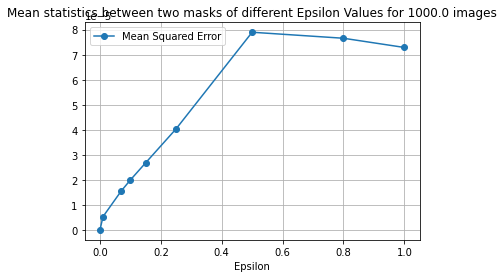

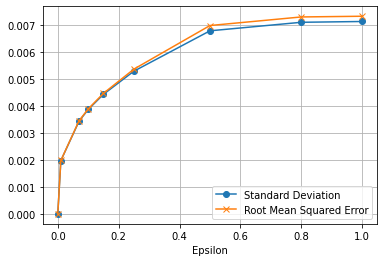

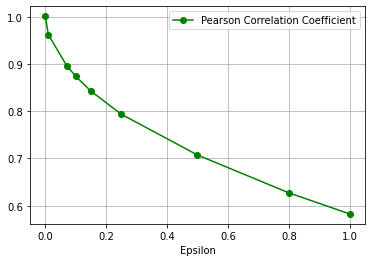

In [ ]:
#@title Calculation for MNIST + Noise
epsilons = [0, 0.01, 0.07, 0.1, 0.15, 0.25, 0.5, 0.8, 1]

x = 1000.0
#x = len(mnist_test_images)/4

mean_errors = [0 for i in range (len(epsilons))]
mean_deviations = [0 for i in range (len(epsilons))]
mean_rmses = [0 for i in range (len(epsilons))]
mean_corrs = [0 for i in range (len(epsilons))]

for i in range(0, int(x)):
    image = np.float32(mnist_test_images[i])
    image = image.reshape(1,28,28,1)
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    errors, deviations, rmses, corrs = noise_calculate_distances_of_masks(baseline=baseline_28,image=image,target_class_idx=mnist_test_labels[i].item(),model=mnist_model, epsilons=epsilons)
    mean_errors = np.add(mean_errors, errors)
    mean_deviations = np.add(mean_deviations, deviations)
    mean_rmses = np.add(mean_rmses, rmses)
    mean_corrs = np.add(mean_corrs, corrs)



mean_errors = np.true_divide(mean_errors, x-1)
mean_deviations = np.true_divide(mean_deviations, x-1)
mean_rmses = np.true_divide(mean_rmses, x-1)
mean_corrs = np.true_divide(mean_corrs, x-1)

plot_distances_of_maks(epsilons, mean_errors, mean_deviations, mean_rmses, mean_corrs,x)

In [ ]:
#@title Results of calculations
#Result Data
epsilons = [0, 0.007, 0.01, 0.015, 0.05, 0.07, 0.1, 0.15, 0.25]
#Modelname: selftrained CNN, Dataset = CIFAR, Type = adversarial, X = 1000.0,
selftrained_cifar_mean_errors = [9.32730090e-20, 9.08849074e-06, 1.26545886e-05, 1.79726390e-05, 3.32092274e-05, 3.59230777e-05, 3.85571844e-05, 4.10231870e-05, 4.35977892e-05]
selftrained_cifar_mean_standard_deviation = [2.35361992e-10, 2.15782645e-03, 2.52111465e-03, 2.95914610e-03, 3.84438406e-03, 3.93634416e-03, 4.01472287e-03, 4.07717950e-03, 4.17568843e-03]
selftrained_cifar_mean_corrs = [1.0, 0.87768175, 0.83677618, 0.7772825, 0.56168599, 0.51756139, 0.48185532, 0.45491124, 0.43236231]
selftrained_cifar_mean_misclassifications = [302, 659, 755, 851, 988, 993, 989, 986, 971]
selftrained_cifar_error_rate = [0.302, 0.659, 0.755, 0.851, 0.988, 0.993, 0.989, 0.986, 0.971]
#------------------------------------------------------------------------------------------

#Modelname: selftrained CNN, Dataset = CIFAR-10, Type = Noise, X = 1000.0,
selftrained_cifar_mean_errors_noise = [1.88392035e-19, 6.02268289e-06, 8.29984983e-06, 1.20603430e-05, 3.40672577e-05, 4.34675895e-05, 5.23871774e-05, 6.27103867e-05, 6.65717831e-05]
selftrained_cifar_mean_standard_deviation_noise = [3.27359599e-10, 1.85802479e-03, 2.18011574e-03, 2.62050456e-03, 4.31827022e-03, 4.81712405e-03, 5.20456915e-03, 5.49507243e-03, 5.42544491e-03]
selftrained_cifar_mean_corrs_noise = [1.0, 0.93763648, 0.91582514, 0.88136445, 0.69130017, 0.61448505, 0.53740121, 0.47696749, 0.44317612]
selftrained_cifar_mean_misclassifications_noise = [282, 277, 280, 280, 351, 424, 553, 707, 826]
selftrained_cifar_error_rate_noise = [0.282, 0.277, 0.28,  0.28,  0.351, 0.424, 0.553, 0.707, 0.826]

#-----------------------------------------------------------------------------------------

#Modelname: selftrained CNN, Dataset = F-MNIST, Type = adv, X = 1000.0,
selftrained_mnist_mean_errors = [2.04784694e-21, 6.26367050e-08, 7.77508060e-08, 1.01885428e-07, 2.47824414e-07, 3.15880252e-07, 4.06077809e-07, 5.39024805e-07, 7.50776595e-07]
selftrained_mnist_mean_standard_deviation = [3.55316493e-11, 1.97325447e-04, 2.20377099e-04, 2.52275619e-04, 3.89668771e-04, 4.38827003e-04, 4.93817181e-04, 5.58941927e-04, 6.35332543e-04]
selftrained_mnist_mean_corrs = [1.0, 0.95845945, 0.94910416, 0.93486244, 0.85418465, 0.81720615, 0.77113482, 0.70897889, 0.61992693]
selftrained_mnist_mean_misclassifications = [273, 295, 305, 317, 454, 553, 669, 828, 963]
selftrained_mnist_error_rate = [0.273, 0.295, 0.305, 0.317, 0.454, 0.553, 0.669, 0.828, 0.963]

#-----------------------------------------------------------------------------------------

#Modelname: selftrained CNN, Dataset = F-MNIST, Type = Noise, X = 1000.0,
selftrained_mnist_mean_errors_noise = [2.17305630e-21, 8.79787488e-08, 1.07106346e-07, 1.35184159e-07, 2.71988638e-07, 3.27860834e-07, 3.98000049e-07, 4.97340677e-07, 6.72276198e-07]
selftrained_mnist_mean_standard_deviation_noise = [3.60221790e-11, 2.37066924e-04, 2.62097201e-04, 2.94683009e-04, 4.19855939e-04, 4.62337176e-04, 5.09928981e-04, 5.69870872e-04, 6.57770980e-04]
selftrained_mnist_mean_corrs_noise = [1.0, 0.94043837, 0.92873356, 0.91229571, 0.83292065, 0.80097524, 0.76313339, 0.71483068, 0.6467256]
selftrained_mnist_mean_misclassifications_noise = [273, 274, 274, 275, 277, 282, 288, 299, 365]
selftrained_mnist_error_rate_noise = [0.273, 0.274, 0.274, 0.275, 0.277, 0.282, 0.288, 0.299, 0.365]
#----------------------------------------------------------------------------------------
#Modelname: selftrained CNN, Dataset = F-MNIST, Type = adv, X = 1000.0,
confident_selftrained_mnist_mean_errors = [4.21629769e-20, 3.14090429e-06, 4.13568789e-06, 5.48138468e-06, 1.11558045e-05, 1.25671871e-05, 1.43856086e-05, 1.67480485e-05, 1.87254033e-05]
confident_selftrained_mnist_mean_standard_deviation = [1.67525596e-10, 1.35690302e-03, 1.55854229e-03, 1.79990935e-03, 2.55927315e-03, 2.71884447e-03, 2.87794785e-03, 3.05071191e-03, 3.18343573e-03]
confident_selftrained_mnist_mean_corrs = [1.0, 0.90353155, 0.87665012, 0.83940081, 0.68588527, 0.63417169, 0.57785661, 0.51342404, 0.43792983]
confident_selftrained_mnist_mean_misclassifications = [90, 191, 241, 333, 836, 908, 953, 974, 979]
confident_selftrained_mnist_error_rate = [0.09,  0.191, 0.241, 0.333, 0.836, 0.908, 0.953, 0.974, 0.979]

#Modelname: selftrained CNN, Dataset = F-MNIST, Type = Noise, X = 1000.0,
confident_selftrained_mnist_mean_errors_noise = [4.17810882e-20, 3.05181311e-06, 3.86727180e-06, 4.93468778e-06, 9.71303796e-06, 1.14559422e-05, 1.31351200e-05, 1.44314828e-05, 1.57181604e-05]
confident_selftrained_mnist_mean_standard_deviation_noise = [1.67438581e-10, 1.33963124e-03, 1.51895815e-03, 1.73898278e-03, 2.50734926e-03, 2.73387410e-03, 2.94284039e-03, 3.10073150e-03, 3.21268992e-03]
confident_selftrained_mnist_mean_corrs_noise = [1.0, 0.90758197, 0.88466714, 0.8523275,  0.71167607, 0.66118715, 0.60520216, 0.54227808, 0.46642702]
confident_selftrained_mnist_mean_misclassifications_noise = [90,  91,  89,  88, 108, 117, 138, 201, 349]
confident_selftrained_mnist_error_rate_noise = [0.09,  0.091, 0.089, 0.088, 0.108, 0.117, 0.138, 0.201, 0.349]
#

#Modelname: selftrained CNN, Dataset = Cats vs. Dogs, Type = adv, X = 1024.0,
selftrained_cvsd_mean_errors = [1.16647055e-22, 3.42436728e-09, 4.84267334e-09, 7.47922145e-09, 3.07204292e-08, 4.83371545e-08, 7.99458848e-08, 9.27179565e-08, 4.83511478e-08]
selftrained_cvsd_mean_standard_deviation = [1.01618185e-11, 5.22890855e-05, 6.19475634e-05, 7.58671107e-05, 1.40806417e-04, 1.69936787e-04, 2.07957658e-04, 2.20064246e-04, 1.66574701e-04]
selftrained_cvsd_mean_corrs = [1.0, 0.93502877, 0.91347784, 0.880496, 0.72289557, 0.65985287, 0.58621929, 0.51034547, 0.43263552]
selftrained_cvsd_mean_misclassifications = [192,  480,  736,  960, 1024, 1024, 1024, 1024, 1024]
selftrained_cvsd_error_rate = [0.1875,  0.46875, 0.71875, 0.9375, 1.0, 1.0, 1.0, 1.0, 1.0]

#---------------------------------------------------------------------------------------

#Modelname:selftrained CNN, Dataset = Cats vs. Dogs, Type = Noise, X = 1024.0,
selftrained_cvsd_mean_errors_noise = [1.16880979e-22, 2.39840651e-09, 3.13256377e-09, 4.17186962e-09, 9.11857806e-09, 1.14403107e-08, 1.54068145e-08, 2.66692100e-08, 8.52652855e-08]
selftrained_cvsd_mean_standard_deviation_noise = [1.01763209e-11, 4.51126279e-05, 5.19001560e-05, 6.02654251e-05, 9.00370575e-05, 1.00822659e-04, 1.16194001e-04, 1.47360932e-04, 2.37153875e-04]
selftrained_cvsd_mean_corrs_noise = [1.0, 0.94488101, 0.92757682, 0.90330967, 0.79478162, 0.75111015, 0.69277484, 0.60563085, 0.47719294]
selftrained_cvsd_mean_misclassifications_noise = [192, 192, 192, 192, 207, 176, 191, 273, 319]
selftrained_cvsd_error_rate_noise = [0.1875, 0.1875, 0.1875, 0.1875, 0.20214844, 0.171875, 0.18652344, 0.26660156, 0.31152344]

inception_cvsd_error_rate = [0.03125, 0.1875, 0.1875, 0.1875, 0.1875, 0.125, 0.15625, 0.125, 0.0625]
inception_cvsd_error_rate_noise = [0.03125, 0.05175781, 0.05664062, 0.05371094, 0.05664062, 0.06835938, 0.07519531, 0.14160156, 0.36328125]
cifar_standard_deviation_on_adversarial_masks = [0.00374701, 0.00353041, 0.00329359, 0.0028614,  0.00136604, 0.00114685,0.00102079, 0.00105952, 0.00109549]

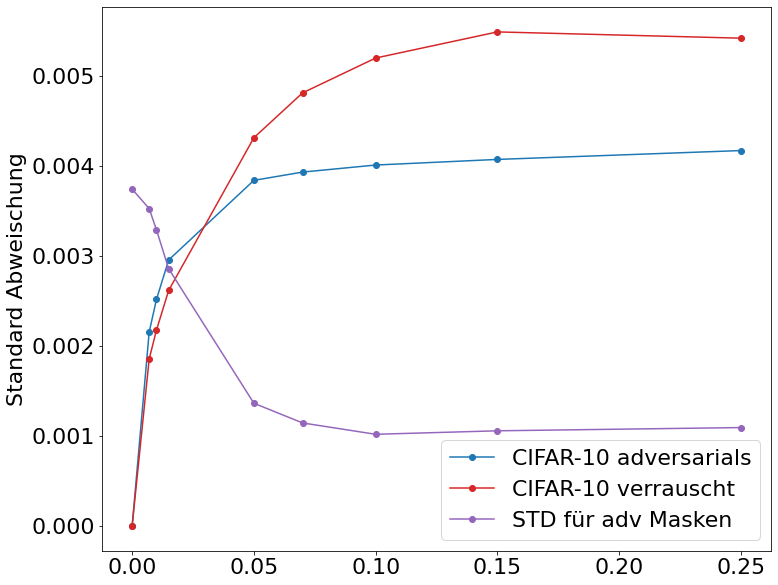

In [ ]:
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(nrows=1, ncols= 1, figsize = (12, 10))
ax.plot(epsilons, selftrained_cifar_mean_standard_deviation, marker="o", color="C0", label="CIFAR-10 adversarials")
ax.plot(epsilons, selftrained_cifar_mean_standard_deviation_noise, marker="o", color="C3", label="CIFAR-10 verrauscht")

ax.plot(epsilons, tmp, marker="o", color="C4", label="STD für adv Masken")
ax.legend()
ax.set(ylabel="Standard Abweischung")
fig.savefig("wertebereich.svg", format="svg")

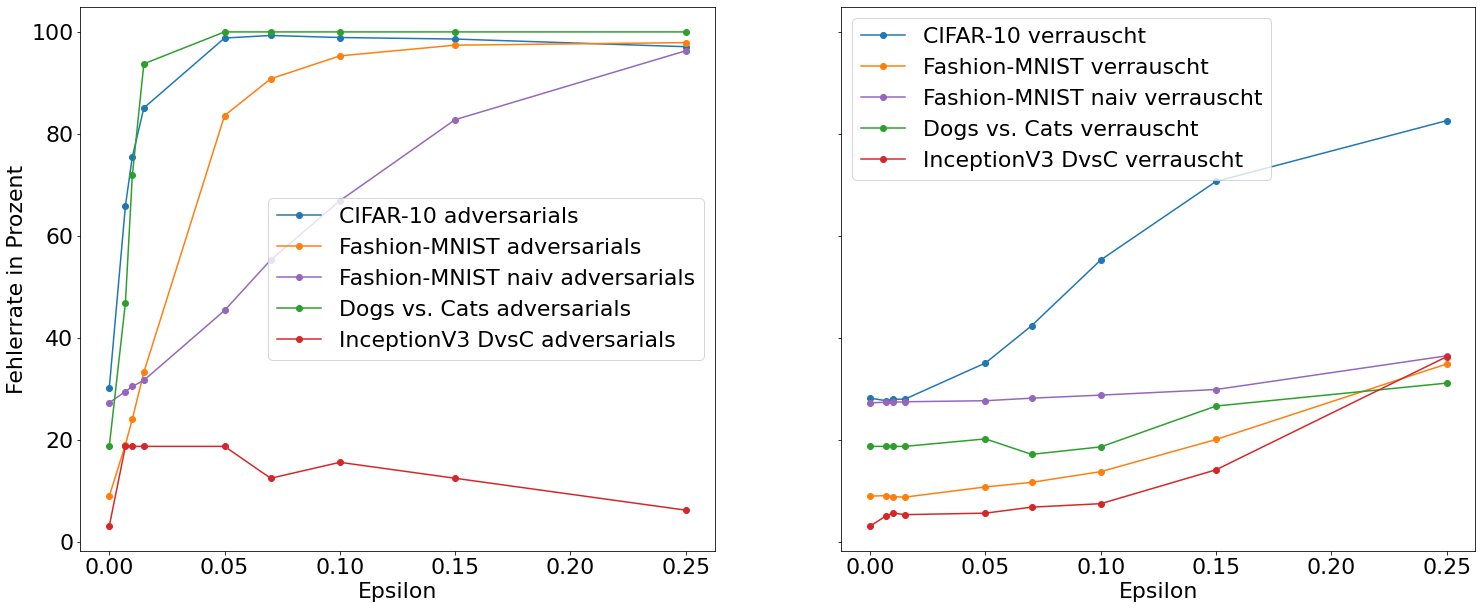

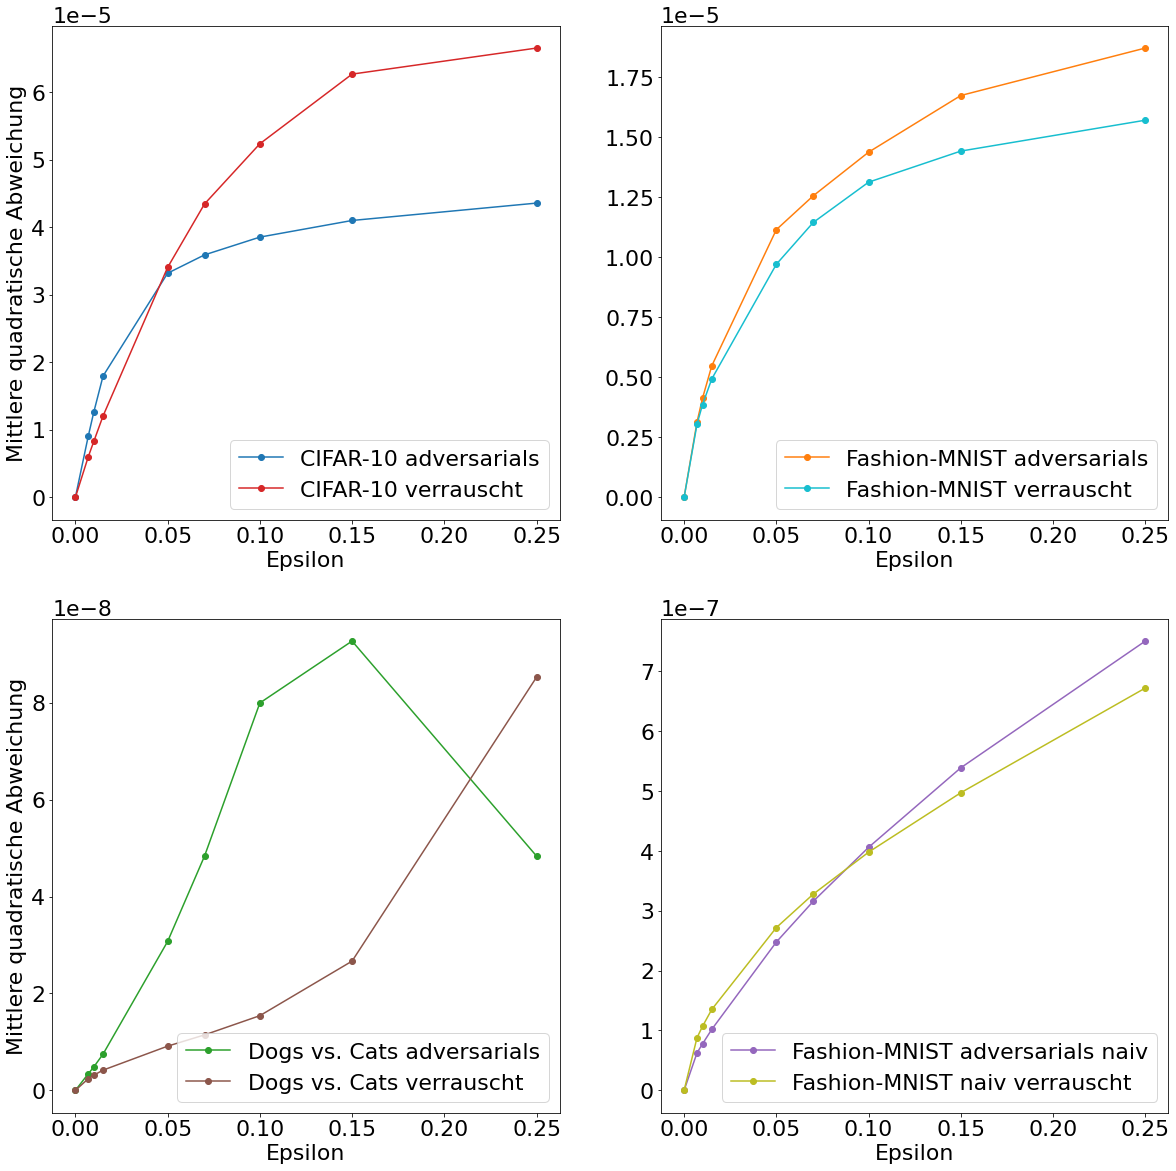

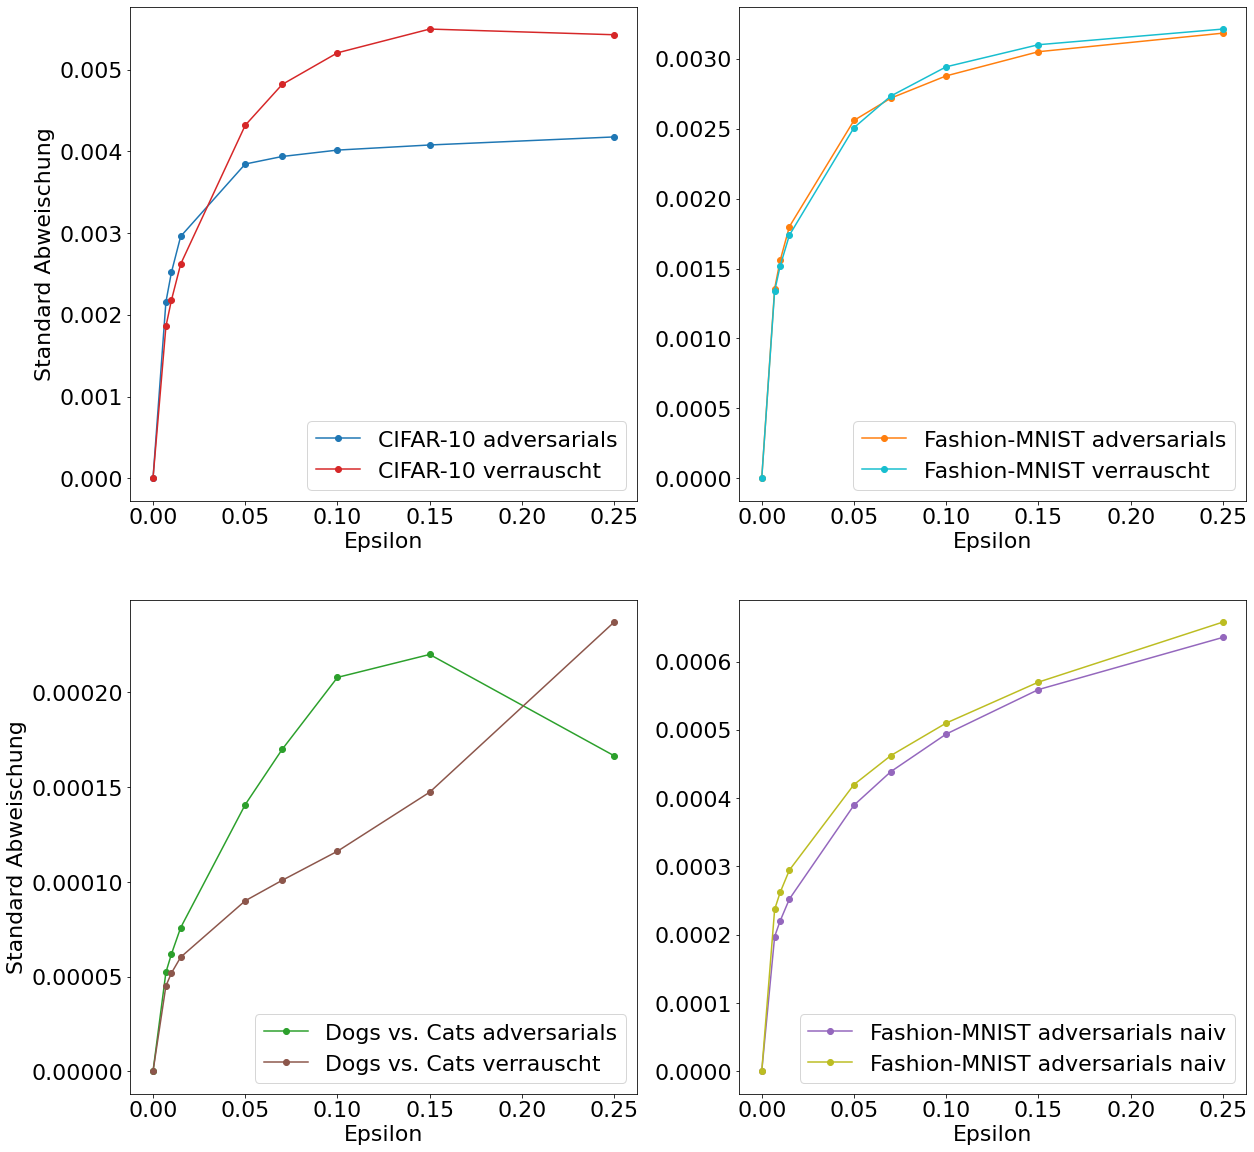

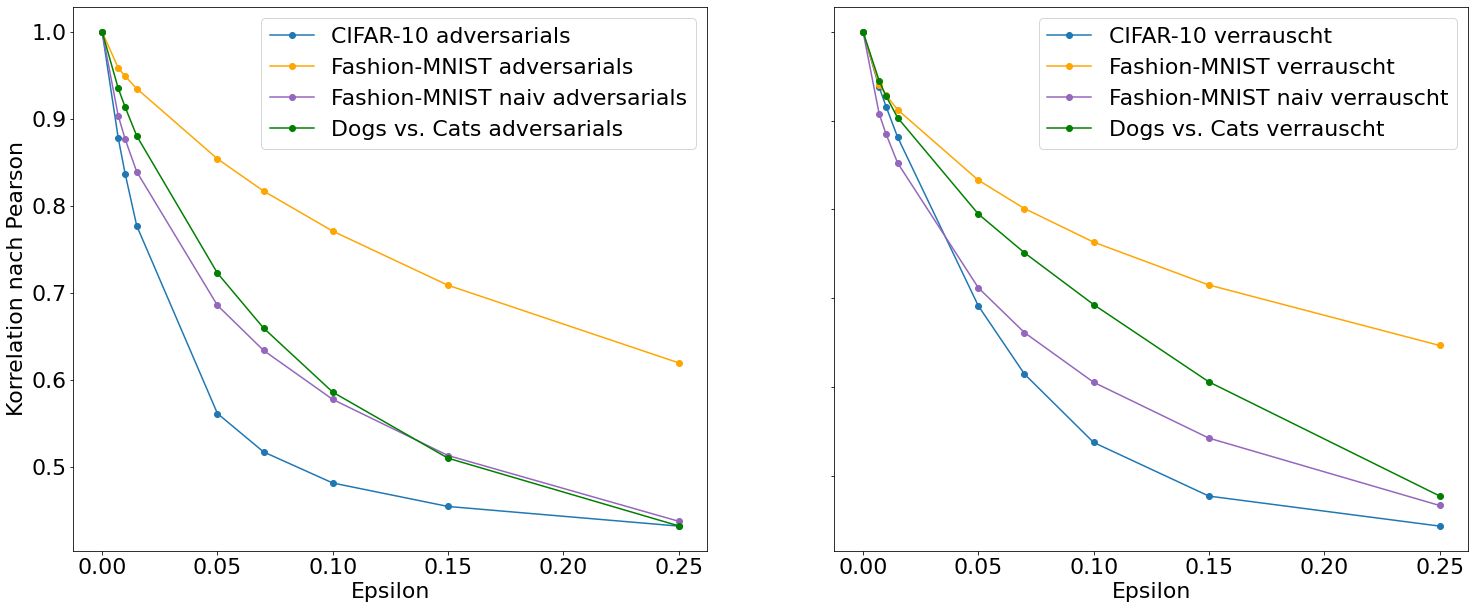

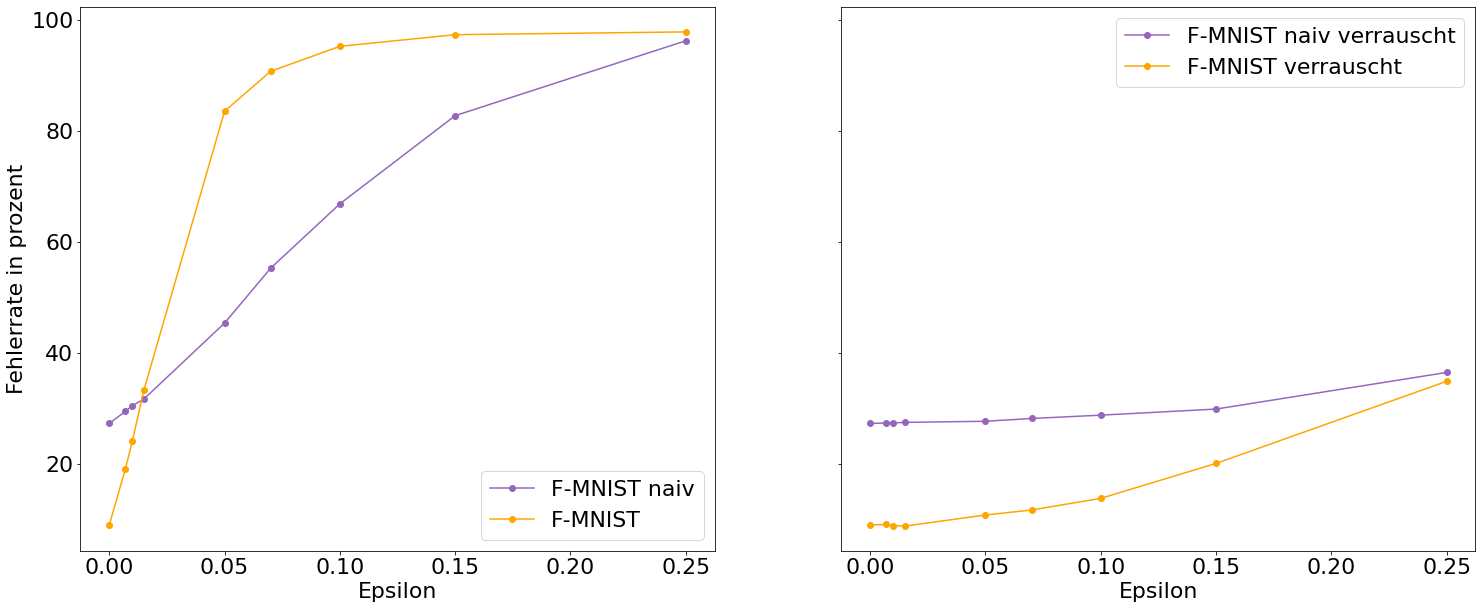

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 22})
fig, axs = plt.subplots(nrows=1, ncols=2, squeeze=False, figsize=(25, 10), sharey=True)
#fig.suptitle("Durchschnittliche Fehlerrate beim Erkennen von gestörten Bilder")
axs[0, 0].plot(epsilons, np.array([100*x for x in selftrained_cifar_error_rate]), marker="o", label="CIFAR-10 adversarials")
axs[0, 0].plot(epsilons, np.array([100*x for x in confident_selftrained_mnist_error_rate]), marker="o",label="Fashion-MNIST adversarials")
axs[0, 0].plot(epsilons, np.array([100*x for x in selftrained_mnist_error_rate]), marker="o",color="C4", label="Fashion-MNIST naiv adversarials")
axs[0, 0].plot(epsilons, np.array([100*x for x in selftrained_cvsd_error_rate]), marker="o",label="Dogs vs. Cats adversarials")
axs[0, 0].plot(epsilons, np.array([100*x for x in inception_cvsd_error_rate]), marker="o",label="InceptionV3 DvsC adversarials")
axs[0, 0].legend()

axs[0, 1].plot(epsilons, np.array([100*x for x in selftrained_cifar_error_rate_noise]), marker="o",label="CIFAR-10 verrauscht")
axs[0, 1].plot(epsilons, np.array([100*x for x in confident_selftrained_mnist_error_rate_noise]), marker="o",label="Fashion-MNIST verrauscht")
axs[0, 1].plot(epsilons, np.array([100*x for x in selftrained_mnist_error_rate_noise]), marker="o",color="C4", label="Fashion-MNIST naiv verrauscht")
axs[0, 1].plot(epsilons, np.array([100*x for x in selftrained_cvsd_error_rate_noise]), marker="o",label="Dogs vs. Cats verrauscht")
axs[0, 1].plot(epsilons, np.array([100*x for x in inception_cvsd_error_rate_noise]), marker="o",label="InceptionV3 DvsC verrauscht")

axs[0, 1].legend()


for ax in axs.flat:
    ax.set(xlabel='Epsilon', ylabel='Fehlerrate in Prozent')
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig.savefig("error_rate.svg", format="svg")

fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(20, 20))
#fig.suptitle("MSE")
axs[0, 0].plot(epsilons, selftrained_cifar_mean_errors, marker="o", color="C0", label="CIFAR-10 adversarials")
axs[0, 1].plot(epsilons, confident_selftrained_mnist_mean_errors, marker="o", color="C1", label="Fashion-MNIST adversarials")
axs[1, 1].plot(epsilons, selftrained_mnist_mean_errors, marker="o", color="C4", label="Fashion-MNIST adversarials naiv")
axs[1, 0].plot(epsilons, selftrained_cvsd_mean_errors, marker="o", color="C2", label="Dogs vs. Cats adversarials")

axs[0, 0].plot(epsilons, selftrained_cifar_mean_errors_noise, marker="o", color="C3", label="CIFAR-10 verrauscht")
axs[0, 1].plot(epsilons, confident_selftrained_mnist_mean_errors_noise, marker="o", color="C9", label="Fashion-MNIST verrauscht")
axs[1, 1].plot(epsilons, selftrained_mnist_mean_errors_noise, marker="o", color="C8", label="Fashion-MNIST naiv verrauscht")
axs[1, 0].plot(epsilons, selftrained_cvsd_mean_errors_noise, marker="o", color="C5", label="Dogs vs. Cats verrauscht")
axs[0, 0].legend()
axs[0, 1].legend()
axs[1, 1].legend()
axs[1, 0].legend(loc='lower right')




for ax in axs.flat:
    if(ax == axs.flat[0] or ax == axs.flat[2]):
        ax.set(ylabel='Mittlere quadratische Abweichung')
    ax.set(xlabel='Epsilon')
    #ax.legend()
# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
#    ax.label_outer()

fig.savefig("mse.svg", format="svg")



fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(20, 20))
#fig.suptitle("STD")
axs[0, 0].plot(epsilons, selftrained_cifar_mean_standard_deviation, marker="o", color="C0", label="CIFAR-10 adversarials")
axs[0, 1].plot(epsilons, confident_selftrained_mnist_mean_standard_deviation, marker="o", color="C1", label="Fashion-MNIST adversarials")
axs[1, 1].plot(epsilons, selftrained_mnist_mean_standard_deviation, marker="o", color="C4", label="Fashion-MNIST adversarials naiv")
axs[1, 0].plot(epsilons, selftrained_cvsd_mean_standard_deviation, marker="o", color="C2", label="Dogs vs. Cats adversarials")
axs[0, 0].legend()

axs[0, 0].plot(epsilons, selftrained_cifar_mean_standard_deviation_noise, marker="o", color="C3", label="CIFAR-10 verrauscht")
axs[0, 1].plot(epsilons, confident_selftrained_mnist_mean_standard_deviation_noise, marker="o", color="C9", label="Fashion-MNIST verrauscht")
axs[1, 1].plot(epsilons, selftrained_mnist_mean_standard_deviation_noise, marker="o", color="C8", label="Fashion-MNIST adversarials naiv")
axs[1, 0].plot(epsilons, selftrained_cvsd_mean_standard_deviation_noise, marker="o", color="C5", label="Dogs vs. Cats verrauscht")
axs[0, 1].legend()


for ax in axs.flat:
    if(ax == axs.flat[0] or ax == axs.flat[2]):
        ax.set(ylabel='Standard Abweischung')
    ax.set(xlabel='Epsilon')
    ax.legend()
# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
#    ax.label_outer()

fig.savefig("std.svg", format="svg")

fig, axs = plt.subplots(nrows=1, ncols=2, squeeze=False, figsize=(25, 10))
#fig.suptitle("Korrelation")
axs[0, 0].plot(epsilons, selftrained_cifar_mean_corrs, marker="o", label="CIFAR-10 adversarials")
axs[0, 0].plot(epsilons, selftrained_mnist_mean_corrs, marker="o", color="orange", label="Fashion-MNIST adversarials")
axs[0, 0].plot(epsilons, confident_selftrained_mnist_mean_corrs, marker="o", color="C4", label="Fashion-MNIST naiv adversarials")
axs[0, 0].plot(epsilons, selftrained_cvsd_mean_corrs, marker="o", color="green", label="Dogs vs. Cats adversarials")
axs[0, 0].legend()

axs[0, 1].plot(epsilons, selftrained_cifar_mean_corrs_noise, marker="o", label="CIFAR-10 verrauscht")
axs[0, 1].plot(epsilons, selftrained_mnist_mean_corrs_noise, marker="o", color="orange", label="Fashion-MNIST verrauscht")
axs[0, 1].plot(epsilons, confident_selftrained_mnist_mean_corrs_noise, marker="o", color="C4", label="Fashion-MNIST naiv verrauscht")
axs[0, 1].plot(epsilons, selftrained_cvsd_mean_corrs_noise, marker="o", color="green", label="Dogs vs. Cats verrauscht")
axs[0, 1].legend()


for ax in axs.flat:
    ax.set(xlabel='Epsilon', ylabel='Korrelation nach Pearson')
    ax.legend()
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig.savefig("corrs.svg", format="svg")

fig, axs = plt.subplots(nrows=1, ncols=2, squeeze=False, figsize=(25, 10), sharey=True)
#fig.suptitle("MNIST vs confident MNIST")
axs[0, 0].plot(epsilons, np.array([100*x for x in selftrained_mnist_error_rate]), marker="o", color="C4" , label="F-MNIST naiv")
axs[0, 1].plot(epsilons, np.array([100*x for x in selftrained_mnist_error_rate_noise]), marker="o", color="C4" , label="F-MNIST naiv verrauscht")

axs[0, 0].plot(epsilons, np.array([100*x for x in confident_selftrained_mnist_error_rate]), marker="o", color="orange" ,label="F-MNIST")
axs[0, 1].plot(epsilons, np.array([100*x for x in confident_selftrained_mnist_error_rate_noise]), marker="o", color="orange", label="F-MNIST verrauscht")


for ax in axs.flat:
    ax.set(xlabel='Epsilon', ylabel='Fehlerrate in prozent')
    ax.legend()
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig.savefig("vs.svg", format="svg")